# Air Quality Forecasting Pipeline
This notebook builds XGBoost, temporal LSTM, and spatio-temporal LSTM models for Delhi air quality forecasting across seven monitoring stations.

In [6]:
# !pip install -qU numpy pandas matplotlib seaborn scikit-learn xgboost torch optuna

In [7]:
!pip install -qU optuna

In [8]:
print("[DEBUG] Importing core libraries...")
import warnings
warnings.filterwarnings("ignore")
import os
import math
import time
from pathlib import Path

import numpy as np
import pandas as pd
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

from optuna.exceptions import TrialPruned

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
print("[DEBUG] Libraries loaded.")

[DEBUG] Importing core libraries...
[DEBUG] Libraries loaded.


In [9]:
print("[DEBUG] Setting global configuration...")
BASE_DIR = Path("./PS2-SIH25").resolve()
DATA_DIR = BASE_DIR / "Data_SIH_2025 2"
SITE_IDS = [f"site_{i}" for i in range(1, 8)]
TRAIN_SUFFIX = "_train_data.csv"
UNSEEN_SUFFIX = "_unseen_input_data.csv"
TARGET_COLUMNS = ["O3_target", "NO2_target"]
FORECAST_COLUMNS = ["O3_forecast", "NO2_forecast", "T_forecast", "q_forecast", "u_forecast", "v_forecast", "w_forecast"]
SATELLITE_COLUMNS = ["NO2_satellite", "HCHO_satellite", "ratio_satellite"]
TIME_COLUMNS = ["year", "month", "day", "hour"]
BASE_FEATURE_COLUMNS = TIME_COLUMNS + FORECAST_COLUMNS + SATELLITE_COLUMNS
TREE_LAG_WINDOW = 24
TREE_HORIZON = 24
TEMPORAL_WINDOW = 48
TEMPORAL_HORIZON = 24
SPATIAL_WINDOW = 72
SPATIAL_HORIZON = 48
TREE_ROLLING_WINDOWS = [6, 24]
SEQUENCE_ROLLING_WINDOWS = [6, 24]
SPATIAL_ROLLING_WINDOWS = [6, 24]
SPATIAL_TOP_K_NEIGHBORS = 2
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
RESULTS = {}
print(f"[DEBUG] Base dir: {BASE_DIR}")
print(f"[DEBUG] Data dir: {DATA_DIR}")
print(f"[DEBUG] Using device: {DEVICE}")

[DEBUG] Setting global configuration...
[DEBUG] Base dir: /content/PS2-SIH25
[DEBUG] Data dir: /content/PS2-SIH25/Data_SIH_2025 2
[DEBUG] Using device: cuda


In [10]:
print("[DEBUG] Defining data utility helpers...")

def ensure_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df[["year", "month", "day", "hour"]], errors="coerce")
    return df

def load_site_dataframe(site_id: str, kind: str = "train") -> pd.DataFrame:
    suffix = TRAIN_SUFFIX if kind == "train" else UNSEEN_SUFFIX
    path = DATA_DIR / f"{site_id}{suffix}"
    print(f"[DEBUG] Loading {kind} data for {site_id} from {path}")
    df = pd.read_csv(path)
    df["site_id"] = site_id
    df = ensure_timestamp(df)
    df = df.sort_values("timestamp").reset_index(drop=True)
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns.tolist()
    df[numeric_cols] = df[numeric_cols].interpolate().ffill().bfill()
    return df


def add_rolling_features(df: pd.DataFrame, columns: list[str], windows: list[int], group_key: str = "site_id") -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        if col not in df.columns:
            continue
        for window in windows:
            feature_name = f"{col}_roll_mean_{window}"
            df[feature_name] = (
                df.groupby(group_key)[col]
                  .transform(lambda s: s.shift(1).rolling(window, min_periods=1).mean())
            )
    return df


def load_all_train_data() -> pd.DataFrame:
    frames = [load_site_dataframe(site_id, kind="train") for site_id in SITE_IDS]
    combined = pd.concat(frames, axis=0, ignore_index=True)
    combined = combined.sort_values(["timestamp", "site_id"]).reset_index(drop=True)
    print(f"[DEBUG] Combined train rows: {len(combined)}")
    return combined

def load_lat_lon() -> pd.DataFrame:
    path = DATA_DIR / "lat_lon_sites.txt"
    print(f"[DEBUG] Loading coordinates from {path}")
    coords = pd.read_csv(path, sep="	")
    coords.columns = ["site", "latitude", "longitude"]
    coords["site_id"] = coords["site"].apply(lambda x: f"site_{int(x)}")
    return coords[["site_id", "latitude", "longitude"]]

def chronological_split(df: pd.DataFrame, split_ratio: float = 0.8):
    unique_ts = np.sort(df["timestamp"].unique())
    cutoff_index = int(len(unique_ts) * split_ratio)
    cutoff_index = max(1, min(cutoff_index, len(unique_ts) - 1))
    cutoff = unique_ts[cutoff_index]
    train_mask = df["timestamp"] <= cutoff
    train_df = df.loc[train_mask].reset_index(drop=True)
    val_df = df.loc[~train_mask].reset_index(drop=True)
    print(f"[DEBUG] Chronological split at {cutoff} -> train {len(train_df)}, val {len(val_df)}")
    return train_df, val_df

[DEBUG] Defining data utility helpers...


In [11]:
print("[DEBUG] Loading datasets and coordinates...")
ALL_TRAIN_DF = load_all_train_data()
LAT_LON_DF = load_lat_lon()
print("[DEBUG] Training dataframe columns:", ALL_TRAIN_DF.columns.tolist())
print("[DEBUG] Coordinate dataframe head:")
print(LAT_LON_DF.head())

[DEBUG] Loading datasets and coordinates...
[DEBUG] Loading train data for site_1 from /content/PS2-SIH25/Data_SIH_2025 2/site_1_train_data.csv
[DEBUG] Loading train data for site_2 from /content/PS2-SIH25/Data_SIH_2025 2/site_2_train_data.csv
[DEBUG] Loading train data for site_3 from /content/PS2-SIH25/Data_SIH_2025 2/site_3_train_data.csv
[DEBUG] Loading train data for site_4 from /content/PS2-SIH25/Data_SIH_2025 2/site_4_train_data.csv
[DEBUG] Loading train data for site_5 from /content/PS2-SIH25/Data_SIH_2025 2/site_5_train_data.csv
[DEBUG] Loading train data for site_6 from /content/PS2-SIH25/Data_SIH_2025 2/site_6_train_data.csv
[DEBUG] Loading train data for site_7 from /content/PS2-SIH25/Data_SIH_2025 2/site_7_train_data.csv
[DEBUG] Combined train rows: 171679
[DEBUG] Loading coordinates from /content/PS2-SIH25/Data_SIH_2025 2/lat_lon_sites.txt
[DEBUG] Training dataframe columns: ['year', 'month', 'day', 'hour', 'O3_forecast', 'NO2_forecast', 'T_forecast', 'q_forecast', 'u_for

In [12]:
print("[DEBUG] Summarizing dataset coverage...")
time_span = (ALL_TRAIN_DF["timestamp"].min(), ALL_TRAIN_DF["timestamp"].max())
missing_targets = ALL_TRAIN_DF[TARGET_COLUMNS].isna().sum()
site_counts = ALL_TRAIN_DF.groupby("site_id").size()
print(f"[DEBUG] Time span: {time_span[0]} -> {time_span[1]}")
print("[DEBUG] Missing target counts:")
print(missing_targets)
print("[DEBUG] Samples per site:")
print(site_counts)

[DEBUG] Summarizing dataset coverage...
[DEBUG] Time span: 2019-07-10 00:00:00 -> 2024-06-30 00:00:00
[DEBUG] Missing target counts:
O3_target     0
NO2_target    0
dtype: int64
[DEBUG] Samples per site:
site_id
site_1    25081
site_2    25969
site_3    21913
site_4    24505
site_5    25081
site_6    26353
site_7    22777
dtype: int64


In [13]:

print("[DEBUG] Computing inter-site correlations for targets...")

def compute_target_correlations(df: pd.DataFrame, targets: list[str]) -> pd.DataFrame:
    matrices = []
    for target in targets:
        pivot = df.pivot_table(index="timestamp", columns="site_id", values=target)
        corr = pivot.corr().abs().fillna(0.0)
        matrices.append(corr)
    combined = sum(matrices) / max(len(matrices), 1)
    np.fill_diagonal(combined.values, 0.0)
    return combined

SITE_CORRELATION_MATRIX = compute_target_correlations(ALL_TRAIN_DF, TARGET_COLUMNS)
print("[DEBUG] Target correlation matrix (avg abs):")
print(SITE_CORRELATION_MATRIX)

def build_neighbor_correlations(corr_matrix: pd.DataFrame, top_k: int) -> dict[str, pd.Series]:
    neighbor_map: dict[str, pd.Series] = {}
    for site_id in corr_matrix.index:
        sorted_corr = corr_matrix.loc[site_id].sort_values(ascending=False)
        top_corr = sorted_corr.head(top_k)
        if top_corr.sum() > 0:
            weights = top_corr / top_corr.sum()
        else:
            weights = pd.Series(dtype=float)
        neighbor_map[site_id] = weights
    return neighbor_map

CORRELATION_NEIGHBORS = build_neighbor_correlations(SITE_CORRELATION_MATRIX, SPATIAL_TOP_K_NEIGHBORS)
print("[DEBUG] Correlation-based neighbor weights:")
for site_id, weights in CORRELATION_NEIGHBORS.items():
    print(f"[DEBUG] {site_id}: {weights.to_dict()}")


[DEBUG] Computing inter-site correlations for targets...
[DEBUG] Target correlation matrix (avg abs):
site_id    site_1    site_2    site_3    site_4    site_5    site_6    site_7
site_id                                                                      
site_1   0.000000  0.654385  0.663380  0.659855  0.657313  0.640115  0.729204
site_2   0.654385  0.000000  0.665049  0.655844  0.669400  0.664361  0.664137
site_3   0.663380  0.665049  0.000000  0.710549  0.698176  0.684371  0.681526
site_4   0.659855  0.655844  0.710549  0.000000  0.669279  0.730503  0.729362
site_5   0.657313  0.669400  0.698176  0.669279  0.000000  0.710617  0.689811
site_6   0.640115  0.664361  0.684371  0.730503  0.710617  0.000000  0.710138
site_7   0.729204  0.664137  0.681526  0.729362  0.689811  0.710138  0.000000
[DEBUG] Correlation-based neighbor weights:
[DEBUG] site_1: {'site_7': 0.5236338790109577, 'site_3': 0.4763661209890423}
[DEBUG] site_2: {'site_5': 0.5016303362235617, 'site_3': 0.4983696637764382

## Part 2 · Baseline XGBoost Model
We engineer lagged temporal features for each site and train separate XGBoost regressors for O₃ and NO₂ targets across a 24 hour forecast horizon.

In [14]:
print("[DEBUG] Defining feature engineering for tree model...")

def add_time_signals(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour_sin"] = np.sin(2 * math.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * math.pi * df["hour"] / 24)
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["dow_sin"] = np.sin(2 * math.pi * df["dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * math.pi * df["dayofweek"] / 7)
    return df

def add_lag_features(df: pd.DataFrame, columns: list[str], window: int) -> pd.DataFrame:
    df = df.copy()
    for col in columns:
        for lag in range(1, window + 1):
            df[f"{col}_lag_{lag}"] = df.groupby("site_id")[col].shift(lag)
    return df

def build_tree_dataset(base_df: pd.DataFrame, target_col: str, horizon: int, lag_window: int) -> pd.DataFrame:
    records = []
    for site_id, site_df in base_df.groupby("site_id"):
        enriched = add_time_signals(site_df)
        enriched = add_rolling_features(enriched, FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS, TREE_ROLLING_WINDOWS)
        enriched = add_lag_features(enriched, FORECAST_COLUMNS + SATELLITE_COLUMNS, lag_window)
        enriched["site_numeric"] = int(site_id.split("_")[1])
        feature_cols = [
            col for col in enriched.columns
            if col not in TARGET_COLUMNS + ["timestamp", "site_id"]
        ]
        base_frame = enriched[["timestamp", "site_id"] + feature_cols].copy()
        for h in range(1, horizon + 1):
            horizon_frame = base_frame.copy()
            horizon_frame["horizon"] = h
            horizon_frame["target"] = enriched[target_col].shift(-h)
            records.append(horizon_frame)
    dataset = pd.concat(records, ignore_index=True)
    dataset = dataset.dropna(subset=["target"])
    print(f"[DEBUG] Tree dataset for {target_col}: {dataset.shape}")
    return dataset

def prepare_tree_matrices(df: pd.DataFrame):
    feature_cols = [col for col in df.columns if col not in ["timestamp", "target", "site_id"]]
    X = df[feature_cols].values
    y = df["target"].values
    return X, y, feature_cols

def evaluate_predictions(y_true, y_pred):
    """Calculate regression metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    # Remove squared=False and calculate RMSE manually
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        "mae": float(mae),
        "rmse": float(rmse),
        "r2": float(r2)
    }

[DEBUG] Defining feature engineering for tree model...


In [15]:
print("[DEBUG] Training XGBoost models for NO₂ and O₃...")
XGB_MODELS = {}
XGB_VALIDATION_FRAMES = {}
for target_col in TARGET_COLUMNS:
    dataset = build_tree_dataset(ALL_TRAIN_DF, target_col, TREE_HORIZON, TREE_LAG_WINDOW)
    train_df, val_df = chronological_split(dataset, split_ratio=0.8)
    X_train, y_train, feature_cols = prepare_tree_matrices(train_df)
    X_val, y_val, _ = prepare_tree_matrices(val_df)

    # Include early_stopping_rounds in the model initialization for older XGBoost versions
    model = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=RANDOM_SEED,
        tree_method="hist",
        n_jobs=-1,
        early_stopping_rounds=30  # Add it here for older versions
    )

    eval_set = [(X_val, y_val)]

    # Simplified fit call
    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False
    )

    # Make predictions and evaluate
    preds = model.predict(X_val)
    metrics = evaluate_predictions(y_val, preds)
    XGB_MODELS[target_col] = {"model": model, "metrics": metrics, "feature_cols": feature_cols}
    enriched_val = val_df.copy()
    enriched_val["prediction"] = preds
    XGB_VALIDATION_FRAMES[target_col] = enriched_val
    print(f"[DEBUG] {target_col} metrics: {metrics}")

RESULTS["xgboost"] = {
    "O3_target": XGB_MODELS["O3_target"]["metrics"],
    "NO2_target": XGB_MODELS["NO2_target"]["metrics"],
}
RESULTS["xgboost"]["macro_mae"] = float(np.mean([m["mae"] for m in RESULTS["xgboost"].values() if isinstance(m, dict)]))
RESULTS["xgboost"]["macro_rmse"] = float(np.mean([m["rmse"] for m in RESULTS["xgboost"].values() if isinstance(m, dict)]))
RESULTS["xgboost"]["macro_r2"] = float(np.mean([m["r2"] for m in RESULTS["xgboost"].values() if isinstance(m, dict) and "r2" in m]))
print(f"[DEBUG] XGBoost macro metrics: MAE={RESULTS['xgboost']['macro_mae']:.4f}, RMSE={RESULTS['xgboost']['macro_rmse']:.4f}, R2={RESULTS['xgboost']['macro_r2']:.4f}")


[DEBUG] Training XGBoost models for NO₂ and O₃...
[DEBUG] Tree dataset for O3_target: (4118196, 288)
[DEBUG] Chronological split at 2023-06-17T14:00:00.000000000 -> train 3289248, val 828948
[DEBUG] O3_target metrics: {'mae': 12.875365536689348, 'rmse': 19.311056661174682, 'r2': 0.6901174442388205}
[DEBUG] Tree dataset for NO2_target: (4118196, 288)
[DEBUG] Chronological split at 2023-06-17T14:00:00.000000000 -> train 3289248, val 828948
[DEBUG] NO2_target metrics: {'mae': 12.707493268980805, 'rmse': 19.00957219181792, 'r2': 0.5728336787784152}
[DEBUG] XGBoost macro metrics: MAE=12.7914, RMSE=19.1603, R2=0.6315


[DEBUG] Plotting XGBoost validation curves...


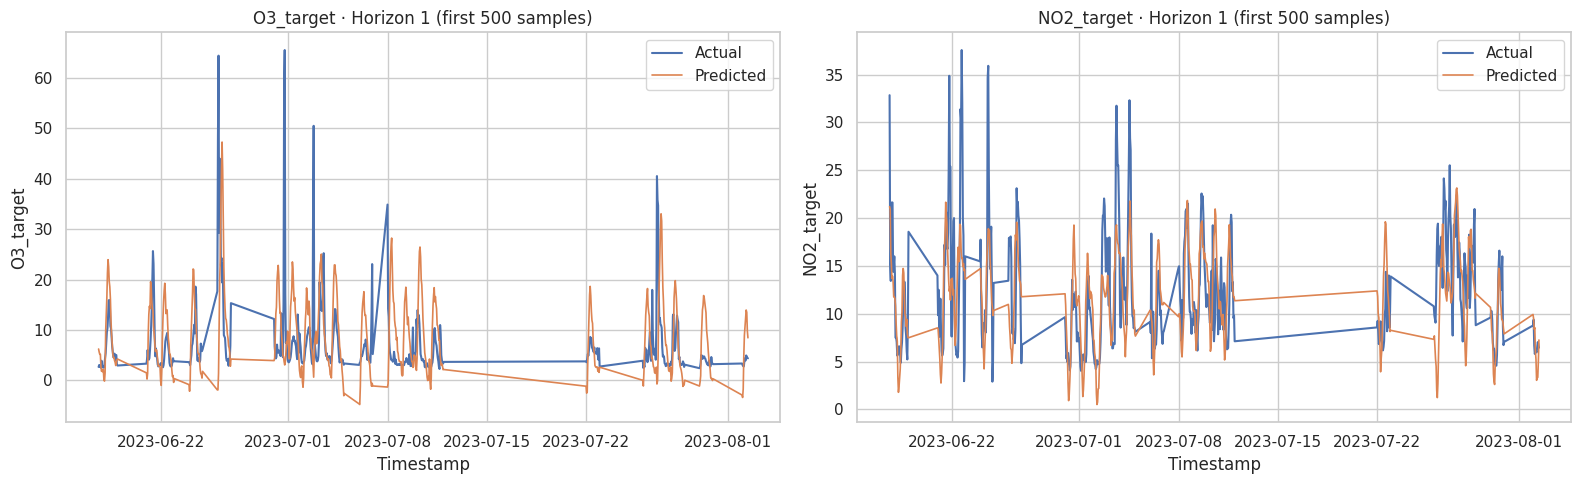

In [16]:
print("[DEBUG] Plotting XGBoost validation curves...")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ax, target_col in zip(axes, TARGET_COLUMNS):
    val_df = XGB_VALIDATION_FRAMES[target_col]
    horizon1 = val_df[val_df["horizon"] == 1].head(500)
    ax.plot(horizon1["timestamp"], horizon1["target"], label="Actual", linewidth=1.5)
    ax.plot(horizon1["timestamp"], horizon1["prediction"], label="Predicted", linewidth=1.2)
    ax.set_title(f"{target_col} · Horizon 1 (first 500 samples)")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel(target_col)
    ax.legend()
plt.tight_layout()
plt.show()

## Part 3 · Temporal LSTM Model
We construct sliding window sequences per station, train an LSTM for joint O₃/NO₂ forecasting over a 24 hour horizon, and evaluate on held-out data.

In [17]:
print("[DEBUG] Defining sequence preparation utilities...")

def build_feature_matrix(df: pd.DataFrame, add_site_one_hot: bool = True) -> tuple[pd.DataFrame, list[str]]:
    base = df.copy()
    base = add_time_signals(base)
    if add_site_one_hot:
        site_dummies = pd.get_dummies(base["site_id"], prefix="site")
        base = pd.concat([base, site_dummies], axis=1)
    feature_cols = [col for col in base.columns if col not in TARGET_COLUMNS + ["timestamp", "site_id"]]
    return base, feature_cols

def generate_sequences(df: pd.DataFrame, feature_cols: list[str], window: int, horizon: int) -> list[dict]:
    sequences = []
    grouped = df.groupby("site_id") if "site_id" in df.columns else [(None, df)]
    for site_id, site_df in grouped:
        site_df = site_df.reset_index(drop=True)
        feat_vals = site_df[feature_cols].to_numpy(dtype=np.float32, na_value=np.nan)
        targ_vals = site_df[TARGET_COLUMNS].to_numpy(dtype=np.float32, na_value=np.nan)
        timestamps = site_df["timestamp"].to_numpy()
        for idx in range(window, len(site_df) - horizon):
            x_window = feat_vals[idx - window: idx]
            y_window = targ_vals[idx: idx + horizon]
            if not np.isfinite(x_window).all() or not np.isfinite(y_window).all():
                continue
            end_ts = timestamps[idx - 1]
            target_ts = timestamps[idx: idx + horizon]
            sequences.append({
                "x": x_window,
                "y": y_window,
                "site_id": site_id,
                "end_ts": end_ts,
                "target_ts": target_ts
            })
    print(f"[DEBUG] Generated {len(sequences)} sequences (window={window}, horizon={horizon})")
    return sequences

def split_sequences(sequences: list[dict], train_ratio: float = 0.7, val_ratio: float = 0.15):
    end_times = np.array([seq["end_ts"] for seq in sequences], dtype="datetime64[ns]")
    sorted_indices = np.argsort(end_times)
    sequences = [sequences[i] for i in sorted_indices]
    total = len(sequences)
    train_end = int(total * train_ratio)
    val_end = int(total * (train_ratio + val_ratio))
    train_seqs = sequences[:train_end]
    val_seqs = sequences[train_end:val_end]
    test_seqs = sequences[val_end:]
    print(f"[DEBUG] Sequence split -> train {len(train_seqs)}, val {len(val_seqs)}, test {len(test_seqs)}")
    return train_seqs, val_seqs, test_seqs

def fit_scalers(train_sequences: list[dict]):
    train_features = np.concatenate([seq["x"] for seq in train_sequences], axis=0)
    train_targets = np.concatenate([seq["y"] for seq in train_sequences], axis=0)
    feature_scaler = StandardScaler().fit(train_features)
    target_scaler = StandardScaler().fit(train_targets)
    print("[DEBUG] Fitted feature and target scalers.")
    return feature_scaler, target_scaler

def apply_scalers(sequences: list[dict], feature_scaler: StandardScaler, target_scaler: StandardScaler):
    scaled = []
    for seq in sequences:
        x_scaled = feature_scaler.transform(seq["x"])
        y_scaled = target_scaler.transform(seq["y"])
        scaled.append({**seq, "x": x_scaled, "y": y_scaled})
    return scaled

class SequenceDataset(Dataset):
    def __init__(self, sequences: list[dict]):
        self.features = torch.tensor(np.stack([seq["x"] for seq in sequences]), dtype=torch.float32)
        self.targets = torch.tensor(np.stack([seq["y"] for seq in sequences]), dtype=torch.float32)

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx: int):
        return self.features[idx], self.targets[idx]

class TemporalLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, horizon: int, target_dim: int, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.horizon = horizon
        self.target_dim = target_dim
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, horizon * target_dim)

    def forward(self, x):
        output, _ = self.lstm(x)
        last_hidden = output[:, -1, :]
        preds = self.fc(last_hidden)
        preds = preds.view(-1, self.horizon, self.target_dim)
        return preds

def train_lstm(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, epochs: int = 25, lr: float = 1e-3, patience: int = 5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float("inf")
    best_state = None
    stale_epochs = 0
    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                preds = model(xb)
                val_losses.append(criterion(preds, yb).item())
        train_loss = float(np.mean(train_losses)) if train_losses else float('nan')
        val_loss = float(np.mean(val_losses)) if val_losses else float('nan')
        print(f"[DEBUG] Epoch {epoch:02d} | train_loss={train_loss:.5f} | val_loss={val_loss:.5f}")
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            stale_epochs = 0
        else:
            stale_epochs += 1
            if stale_epochs >= patience:
                print("[DEBUG] Early stopping triggered.")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def inverse_transform_predictions(preds: np.ndarray, scaler: StandardScaler) -> np.ndarray:
    flat = preds.reshape(-1, preds.shape[-1])
    restored = scaler.inverse_transform(flat)
    return restored.reshape(preds.shape)


[DEBUG] Defining sequence preparation utilities...


In [18]:
print("[DEBUG] Preparing temporal LSTM datasets...")
lstm_base_df = add_rolling_features(ALL_TRAIN_DF, FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS, SEQUENCE_ROLLING_WINDOWS)
feature_dataframe, lstm_feature_cols = build_feature_matrix(lstm_base_df)
sequence_records = generate_sequences(feature_dataframe, lstm_feature_cols, TEMPORAL_WINDOW, TEMPORAL_HORIZON)
train_sequences, val_sequences, test_sequences = split_sequences(sequence_records, train_ratio=0.7, val_ratio=0.15)
feature_scaler, target_scaler = fit_scalers(train_sequences)
train_scaled = apply_scalers(train_sequences, feature_scaler, target_scaler)
val_scaled = apply_scalers(val_sequences, feature_scaler, target_scaler)
test_scaled = apply_scalers(test_sequences, feature_scaler, target_scaler)
train_loader = DataLoader(SequenceDataset(train_scaled), batch_size=128, shuffle=True, drop_last=True)
val_loader = DataLoader(SequenceDataset(val_scaled), batch_size=128, shuffle=False, drop_last=False)
test_loader = DataLoader(SequenceDataset(test_scaled), batch_size=128, shuffle=False, drop_last=False)
print(f"[DEBUG] DataLoaders -> train {len(train_loader.dataset)}, val {len(val_loader.dataset)}, test {len(test_loader.dataset)}")

[DEBUG] Preparing temporal LSTM datasets...
[DEBUG] Generated 171168 sequences (window=48, horizon=24)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] DataLoaders -> train 119817, val 25675, test 25676


In [19]:
print("[DEBUG] Training temporal LSTM...")
input_size = len(lstm_feature_cols)
model_temporal = TemporalLSTM(input_size=input_size, hidden_size=128, horizon=TEMPORAL_HORIZON, target_dim=len(TARGET_COLUMNS)).to(DEVICE)
model_temporal = train_lstm(model_temporal, train_loader, val_loader, epochs=40, lr=1e-3, patience=6)
model_temporal.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        preds = model_temporal(xb).cpu().numpy()
        targets = yb.numpy()
        all_preds.append(preds)
        all_targets.append(targets)
pred_array = np.concatenate(all_preds, axis=0)
target_array = np.concatenate(all_targets, axis=0)
pred_restored = inverse_transform_predictions(pred_array, target_scaler)
target_restored = inverse_transform_predictions(target_array, target_scaler)
flat_true = target_restored.reshape(-1, len(TARGET_COLUMNS))
flat_pred = pred_restored.reshape(-1, len(TARGET_COLUMNS))
target_metrics = {}
for idx, target_col in enumerate(TARGET_COLUMNS):
    metrics = evaluate_predictions(flat_true[:, idx], flat_pred[:, idx])
    target_metrics[target_col] = metrics
    print(f"[DEBUG] Temporal LSTM {target_col} -> MAE={metrics['mae']:.4f}, RMSE={metrics['rmse']:.4f}, R2={metrics['r2']:.4f}")
macro_mae = float(np.mean([m['mae'] for m in target_metrics.values()]))
macro_rmse = float(np.mean([m['rmse'] for m in target_metrics.values()]))
macro_r2 = float(np.mean([m['r2'] for m in target_metrics.values()]))
RESULTS["temporal_lstm"] = {**target_metrics, "macro_mae": macro_mae, "macro_rmse": macro_rmse, "macro_r2": macro_r2}
print(f"[DEBUG] Temporal LSTM macro -> MAE={macro_mae:.4f}, RMSE={macro_rmse:.4f}, R2={macro_r2:.4f}")
TEMPORAL_LSTM_OUTPUT = {
    "predictions": pred_restored,
    "targets": target_restored
}


[DEBUG] Training temporal LSTM...
[DEBUG] Epoch 01 | train_loss=0.30596 | val_loss=0.22384
[DEBUG] Epoch 02 | train_loss=0.18917 | val_loss=0.31713
[DEBUG] Epoch 03 | train_loss=0.14143 | val_loss=0.35266
[DEBUG] Epoch 04 | train_loss=0.11743 | val_loss=0.32498
[DEBUG] Epoch 05 | train_loss=0.10369 | val_loss=0.36671
[DEBUG] Epoch 06 | train_loss=0.09392 | val_loss=0.34425
[DEBUG] Epoch 07 | train_loss=0.08661 | val_loss=0.34409
[DEBUG] Early stopping triggered.
[DEBUG] Temporal LSTM O3_target -> MAE=14.7141, RMSE=22.2623, R2=0.6609
[DEBUG] Temporal LSTM NO2_target -> MAE=16.3930, RMSE=22.8500, R2=0.4210
[DEBUG] Temporal LSTM macro -> MAE=15.5535, RMSE=22.5561, R2=0.5409


[DEBUG] Plotting temporal LSTM predictions...


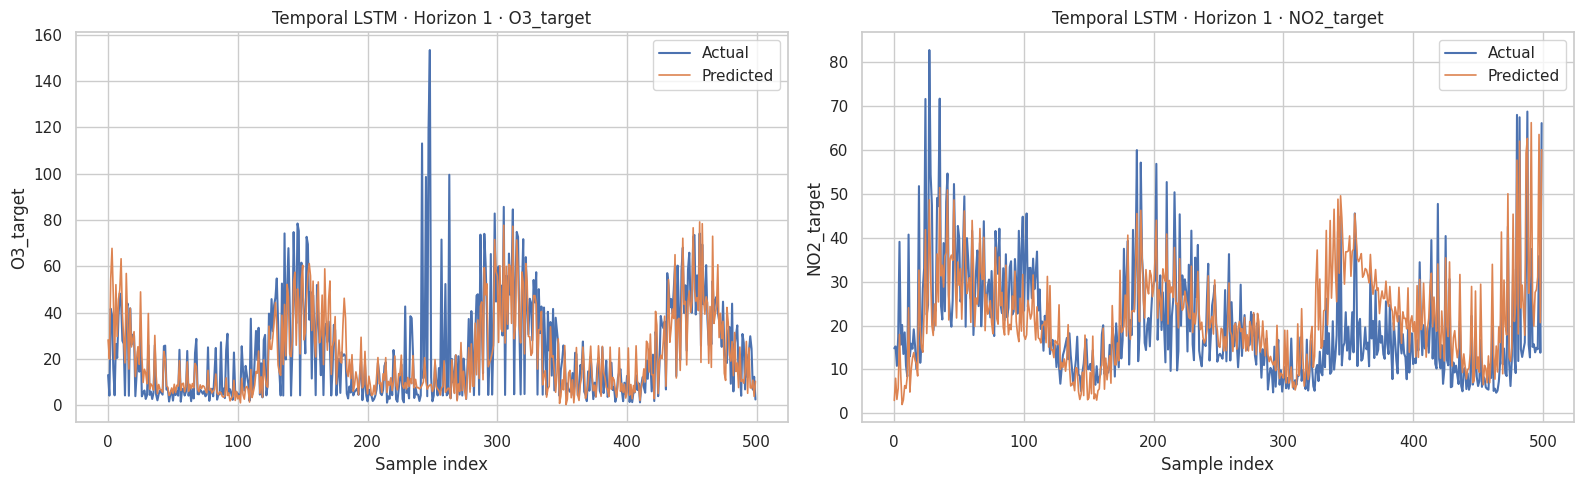

In [20]:
print("[DEBUG] Plotting temporal LSTM predictions...")
horizon_index = 0
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
flattened_pred = TEMPORAL_LSTM_OUTPUT["predictions"][:, horizon_index, :]
flattened_true = TEMPORAL_LSTM_OUTPUT["targets"][:, horizon_index, :]
for idx, target_col in enumerate(TARGET_COLUMNS):
    axes[idx].plot(flattened_true[:500, idx], label="Actual", linewidth=1.5)
    axes[idx].plot(flattened_pred[:500, idx], label="Predicted", linewidth=1.2)
    axes[idx].set_title(f"Temporal LSTM · Horizon {horizon_index + 1} · {target_col}")
    axes[idx].set_xlabel("Sample index")
    axes[idx].set_ylabel(target_col)
    axes[idx].legend()
plt.tight_layout()
plt.show()

## Part 4 · Spatio-Temporal LSTM Model
We enrich the feature set with inverse-distance weighted neighbor information to capture spatial dependencies before training a deeper LSTM with a 48 hour prediction horizon.

In [21]:
# print("[DEBUG] Defining spatial context utilities...")

# def add_neighbor_features(df: pd.DataFrame, neighbor_features: list[str], neighbor_map: dict[str, pd.Series]) -> pd.DataFrame:
#     df = df.copy()
#     available_features = [feature for feature in neighbor_features if feature in df.columns]
#     if not available_features:
#         print("[DEBUG] No valid neighbor features provided.")
#         return df
#     wide = (
#         df.set_index(["timestamp", "site_id"])[available_features]
#           .unstack("site_id")
#     )
#     wide.columns.names = ["feature", "site_id"]
#     current_features = wide.columns.get_level_values("feature").unique().tolist()
#     current_sites = wide.columns.get_level_values("site_id").unique().tolist()
#     feature_levels = [feature for feature in available_features if feature in current_features]
#     site_levels = [site for site in SITE_IDS if site in current_sites]
#     if not feature_levels or not site_levels:
#         print("[DEBUG] No overlapping features/sites for neighbor aggregation.")
#         return df
#     target_columns = pd.MultiIndex.from_product([feature_levels, site_levels])
#     wide = wide.reindex(columns=target_columns)
#     timestamps = wide.index.to_numpy()
#     feature_count = len(feature_levels)
#     site_count = len(site_levels)
#     wide_values = wide.to_numpy(dtype=np.float32).reshape(len(timestamps), feature_count, site_count)
#     site_index = {site: idx for idx, site in enumerate(site_levels)}
#     neighbor_frames: list[pd.DataFrame] = []
#     for site_id, weights in neighbor_map.items():
#         if not isinstance(weights, pd.Series) or site_id not in site_index:
#             continue
#         weights = weights.dropna()
#         available_neighbors = [nbr for nbr in weights.index if nbr in site_index]
#         if not available_neighbors:
#             continue
#         neighbor_weights = weights.loc[available_neighbors].astype(np.float32)
#         total_weight = neighbor_weights.sum()
#         if not np.isfinite(total_weight) or total_weight <= 0:
#             continue
#         neighbor_weights = neighbor_weights / total_weight
#         neighbor_indices = [site_index[nbr] for nbr in available_neighbors]
#         neighbor_tensor = wide_values[:, :, neighbor_indices]
#         aggregated_values = np.tensordot(neighbor_tensor, neighbor_weights.to_numpy(dtype=np.float32), axes=([2], [0]))
#         aggregated_values = aggregated_values.astype(np.float32, copy=False)
#         feature_columns = [f"{feature}_nbr" for feature in feature_levels]
#         neighbor_df = (
#             pd.DataFrame(aggregated_values, index=timestamps, columns=feature_columns)
#               .reset_index()
#               .rename(columns={"index": "timestamp"})
#         )
#         neighbor_df["site_id"] = site_id
#         neighbor_frames.append(neighbor_df)
#     if neighbor_frames:
#         combined_neighbors = pd.concat(neighbor_frames, axis=0, ignore_index=True)
#         df = df.merge(combined_neighbors, on=["timestamp", "site_id"], how="left")
#         df = df.sort_values(["timestamp", "site_id"]).reset_index(drop=True)
#         fill_columns = [col for col in df.columns if col.endswith("_nbr")]
#         if fill_columns:
#             df[fill_columns] = (
#                 df.groupby("site_id")[fill_columns]
#                   .transform(lambda g: g.ffill().bfill())
#             )
#         print("[DEBUG] Added correlation-weighted neighbor features.")
#     else:
#         print("[DEBUG] No neighbor features added.")
#     return df


In [22]:

# print("[DEBUG] Preparing spatio-temporal sequences...")
# spatial_base_df = add_rolling_features(ALL_TRAIN_DF, FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS, SPATIAL_ROLLING_WINDOWS)
# neigh_base_columns = FORECAST_COLUMNS + SATELLITE_COLUMNS
# roll_neighbor_cols = [col for col in spatial_base_df.columns if any(col.startswith(prefix) and "roll_mean" in col for prefix in FORECAST_COLUMNS + SATELLITE_COLUMNS + TARGET_COLUMNS)]
# neighbor_feature_set = neigh_base_columns + roll_neighbor_cols
# spatial_df = add_neighbor_features(spatial_base_df, neighbor_feature_set, CORRELATION_NEIGHBORS)
# spatial_feature_df, spatial_feature_cols = build_feature_matrix(spatial_df, add_site_one_hot=True)
# neigh_cols = [col for col in spatial_feature_df.columns if col.endswith('_nbr')]
# for col in neigh_cols:
#     if col not in spatial_feature_cols:
#         spatial_feature_cols.append(col)
# sequence_records_spatial = generate_sequences(spatial_feature_df, spatial_feature_cols, SPATIAL_WINDOW, SPATIAL_HORIZON)
# train_sequences_spatial, val_sequences_spatial, test_sequences_spatial = split_sequences(sequence_records_spatial, train_ratio=0.7, val_ratio=0.15)
# feature_scaler_spatial, target_scaler_spatial = fit_scalers(train_sequences_spatial)
# train_spatial_scaled = apply_scalers(train_sequences_spatial, feature_scaler_spatial, target_scaler_spatial)
# val_spatial_scaled = apply_scalers(val_sequences_spatial, feature_scaler_spatial, target_scaler_spatial)
# test_spatial_scaled = apply_scalers(test_sequences_spatial, feature_scaler_spatial, target_scaler_spatial)
# train_loader_spatial = DataLoader(SequenceDataset(train_spatial_scaled), batch_size=96, shuffle=True, drop_last=True)
# val_loader_spatial = DataLoader(SequenceDataset(val_spatial_scaled), batch_size=96, shuffle=False, drop_last=False)
# test_loader_spatial = DataLoader(SequenceDataset(test_spatial_scaled), batch_size=96, shuffle=False, drop_last=False)
# print(f"[DEBUG] Spatial DataLoaders -> train {len(train_loader_spatial.dataset)}, val {len(val_loader_spatial.dataset)}, test {len(test_loader_spatial.dataset)}")


In [23]:
# print("[DEBUG] Training spatio-temporal LSTM...")
# input_size_spatial = len(spatial_feature_cols)
# model_spatial = TemporalLSTM(input_size=input_size_spatial, hidden_size=192, horizon=SPATIAL_HORIZON, target_dim=len(TARGET_COLUMNS), num_layers=3, dropout=0.3).to(DEVICE)
# model_spatial = train_lstm(model_spatial, train_loader_spatial, val_loader_spatial, epochs=45, lr=7e-4, patience=7)
# model_spatial.eval()
# spatial_preds = []
# spatial_targets = []
# with torch.no_grad():
#     for xb, yb in test_loader_spatial:
#         xb = xb.to(DEVICE)
#         preds = model_spatial(xb).cpu().numpy()
#         targets = yb.numpy()
#         spatial_preds.append(preds)
#         spatial_targets.append(targets)
# spatial_pred_array = np.concatenate(spatial_preds, axis=0)
# spatial_target_array = np.concatenate(spatial_targets, axis=0)
# spatial_pred_restored = inverse_transform_predictions(spatial_pred_array, target_scaler_spatial)
# spatial_target_restored = inverse_transform_predictions(spatial_target_array, target_scaler_spatial)
# flat_true_spatial = spatial_target_restored.reshape(-1, len(TARGET_COLUMNS))
# flat_pred_spatial = spatial_pred_restored.reshape(-1, len(TARGET_COLUMNS))
# spatial_target_metrics = {}
# for idx, target_col in enumerate(TARGET_COLUMNS):
#     metrics = evaluate_predictions(flat_true_spatial[:, idx], flat_pred_spatial[:, idx])
#     spatial_target_metrics[target_col] = metrics
#     print(f"[DEBUG] Spatio-temporal LSTM {target_col} -> MAE={metrics['mae']:.4f}, RMSE={metrics['rmse']:.4f}, R2={metrics['r2']:.4f}")
# macro_mae_spatial = float(np.mean([m['mae'] for m in spatial_target_metrics.values()]))
# macro_rmse_spatial = float(np.mean([m['rmse'] for m in spatial_target_metrics.values()]))
# macro_r2_spatial = float(np.mean([m['r2'] for m in spatial_target_metrics.values()]))
# RESULTS["spatio_temporal_lstm"] = {
#     **spatial_target_metrics,
#     "macro_mae": macro_mae_spatial,
#     "macro_rmse": macro_rmse_spatial,
#     "macro_r2": macro_r2_spatial,
# }
# print(f"[DEBUG] Spatio-temporal LSTM macro -> MAE={macro_mae_spatial:.4f}, RMSE={macro_rmse_spatial:.4f}, R2={macro_r2_spatial:.4f}")
# SPATIAL_LSTM_OUTPUT = {
#     "predictions": spatial_pred_restored,
#     "targets": spatial_target_restored
# }


In [24]:
# print("[DEBUG] Plotting spatio-temporal LSTM predictions...")
# spatial_horizon_index = 0
# fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# flattened_pred = SPATIAL_LSTM_OUTPUT["predictions"][:, spatial_horizon_index, :]
# flattened_true = SPATIAL_LSTM_OUTPUT["targets"][:, spatial_horizon_index, :]
# for idx, target_col in enumerate(TARGET_COLUMNS):
#     axes[idx].plot(flattened_true[:500, idx], label="Actual", linewidth=1.5)
#     axes[idx].plot(flattened_pred[:500, idx], label="Predicted", linewidth=1.2)
#     axes[idx].set_title(f"Spatio-Temporal LSTM · Horizon {spatial_horizon_index + 1} · {target_col}")
#     axes[idx].set_xlabel("Sample index")
#     axes[idx].set_ylabel(target_col)
#     axes[idx].legend()
# plt.tight_layout()
# plt.show()

## Part 5 · Results Summary
We collate metrics across all models to compare temporal and spatio-temporal performance.

In [25]:
print("[DEBUG] Compiling results summary...")
summary_records = []
for model_name, metrics in RESULTS.items():
    if not isinstance(metrics, dict):
        continue
    target_entries = {
        k: v
        for k, v in metrics.items()
        if isinstance(v, dict) and {'mae', 'rmse', 'r2'}.issubset(v.keys())
    }
    scalar_entries = {k: v for k, v in metrics.items() if not isinstance(v, dict)}
    for target, target_metrics in target_entries.items():
        summary_records.append({
            "model": model_name,
            "target": target,
            "mae": target_metrics.get("mae"),
            "rmse": target_metrics.get("rmse"),
            "r2": target_metrics.get("r2"),
        })
    macro_row = {
        "mae": scalar_entries.get("macro_mae"),
        "rmse": scalar_entries.get("macro_rmse"),
        "r2": scalar_entries.get("macro_r2"),
    }
    if any(val is not None for val in macro_row.values()):
        summary_records.append({
            "model": model_name,
            "target": "macro",
            "mae": macro_row["mae"],
            "rmse": macro_row["rmse"],
            "r2": macro_row["r2"],
        })
    if not target_entries and any(key in scalar_entries for key in ("mae", "rmse", "r2")):
        summary_records.append({
            "model": model_name,
            "target": "joint",
            "mae": scalar_entries.get("mae"),
            "rmse": scalar_entries.get("rmse"),
            "r2": scalar_entries.get("r2"),
        })
RESULTS_TABLE = pd.DataFrame(summary_records).sort_values(["model", "target"]).reset_index(drop=True)
print(RESULTS_TABLE)
xgb_macro_row = RESULTS_TABLE[(RESULTS_TABLE['model'] == 'xgboost') & (RESULTS_TABLE['target'] == 'macro')].iloc[0]
CHAMPION_MODEL = 'xgboost'
print(f"[DEBUG] Champion model declared: XGBoost with macro MAE={xgb_macro_row['mae']:.4f}, RMSE={xgb_macro_row['rmse']:.4f}, R2={xgb_macro_row['r2']:.4f}")


[DEBUG] Compiling results summary...
           model      target        mae       rmse        r2
0  temporal_lstm  NO2_target  16.392963  22.849969  0.421027
1  temporal_lstm   O3_target  14.714085  22.262254  0.660854
2  temporal_lstm       macro  15.553524  22.556111  0.540941
3        xgboost  NO2_target  12.707493  19.009572  0.572834
4        xgboost   O3_target  12.875366  19.311057  0.690117
5        xgboost       macro  12.791429  19.160314  0.631476
[DEBUG] Champion model declared: XGBoost with macro MAE=12.7914, RMSE=19.1603, R2=0.6315


In [26]:
print("[DEBUG] Configuring Optuna utilities for target-specific LSTM search...")
feature_group_template = ['time', 'forecast_raw', 'forecast_roll', 'satellite_raw', 'satellite_roll', 'target_roll', 'site_one_hot', 'other']
FEATURE_GROUPS = {key: [] for key in feature_group_template}
time_features = {'year', 'month', 'day', 'hour', 'dayofweek', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'}
for col in lstm_feature_cols:
    if col.startswith('site_'):
        FEATURE_GROUPS['site_one_hot'].append(col)
    elif '_target_roll_mean_' in col:
        FEATURE_GROUPS['target_roll'].append(col)
    elif '_forecast_roll_mean_' in col:
        FEATURE_GROUPS['forecast_roll'].append(col)
    elif '_satellite_roll_mean_' in col:
        FEATURE_GROUPS['satellite_roll'].append(col)
    elif col.endswith('_forecast'):
        FEATURE_GROUPS['forecast_raw'].append(col)
    elif col.endswith('_satellite'):
        FEATURE_GROUPS['satellite_raw'].append(col)
    elif col in time_features:
        FEATURE_GROUPS['time'].append(col)
    else:
        FEATURE_GROUPS['other'].append(col)
FEATURE_GROUPS = {key: sorted(vals) for key, vals in FEATURE_GROUPS.items() if vals}
ESSENTIAL_GROUPS = [key for key in ('time', 'forecast_raw') if key in FEATURE_GROUPS]
OPTIONAL_GROUPS = [key for key in ('forecast_roll', 'satellite_raw', 'satellite_roll', 'target_roll', 'site_one_hot', 'other') if key in FEATURE_GROUPS]
TARGET_SEQUENCE_CACHE: dict[tuple, dict] = {}
TARGET_LSTM_DETAILS: dict[str, dict] = {}

def select_feature_subset(trial, target_col):
    selected_groups = list(ESSENTIAL_GROUPS)
    for group in OPTIONAL_GROUPS:
        flag = trial.suggest_categorical(f'{target_col}_use_{group}', [0, 1])
        if flag == 1:
            selected_groups.append(group)
    features = []
    for group in selected_groups:
        features.extend(FEATURE_GROUPS.get(group, []))
    features = sorted(dict.fromkeys(features))
    if not features:
        raise TrialPruned('No features selected.')
    return features

def project_sequences_to_target(sequences, target_col):
    idx = TARGET_COLUMNS.index(target_col)
    projected = []
    for seq in sequences:
        projected.append({**seq, 'y': seq['y'][:, [idx]]})
    return projected

def get_sequence_bundle(target_col, feature_cols, window, horizon):
    key = (target_col, tuple(feature_cols), window, horizon)
    if key not in TARGET_SEQUENCE_CACHE:
        sequences = generate_sequences(feature_dataframe, feature_cols, window, horizon)
        if len(sequences) == 0:
            raise ValueError('No sequences generated.')
        projected = project_sequences_to_target(sequences, target_col)
        train_seq, val_seq, test_seq = split_sequences(projected, train_ratio=0.7, val_ratio=0.15)
        if len(train_seq) == 0 or len(val_seq) == 0:
            raise ValueError('Insufficient sequences for split.')
        feature_scaler, target_scaler = fit_scalers(train_seq)
        bundle = {
            'train': apply_scalers(train_seq, feature_scaler, target_scaler),
            'val': apply_scalers(val_seq, feature_scaler, target_scaler),
            'test': apply_scalers(test_seq, feature_scaler, target_scaler),
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler,
            'feature_cols': list(feature_cols),
            'window': window,
            'horizon': horizon,
        }
        TARGET_SEQUENCE_CACHE[key] = bundle
    return TARGET_SEQUENCE_CACHE[key]

def build_dataloaders(bundle, batch_size):
    train_loader = DataLoader(SequenceDataset(bundle['train']), batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(SequenceDataset(bundle['val']), batch_size=batch_size, shuffle=False, drop_last=False)
    return train_loader, val_loader

def evaluate_loader(model, loader, scaler):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            preds.append(model(xb).cpu().numpy())
            targets.append(yb.numpy())
    if not preds:
        raise ValueError('Empty evaluation batch.')
    pred_array = np.concatenate(preds, axis=0)
    target_array = np.concatenate(targets, axis=0)
    pred_restored = inverse_transform_predictions(pred_array, scaler)
    target_restored = inverse_transform_predictions(target_array, scaler)
    flat_pred = pred_restored.reshape(-1)
    flat_true = target_restored.reshape(-1)
    return evaluate_predictions(flat_true, flat_pred)

def build_objective(target_col):
    def objective(trial):
        window = trial.suggest_categorical(f'{target_col}_window', [36, 48, 60, 72])
        horizon = trial.suggest_categorical(f'{target_col}_horizon', [12, 24, 36])
        feature_cols = select_feature_subset(trial, target_col)
        try:
            bundle = get_sequence_bundle(target_col, feature_cols, window, horizon)
        except ValueError as err:
            raise TrialPruned(str(err)) from err
        batch_size = trial.suggest_categorical(f'{target_col}_batch_size', [64, 96, 128])
        hidden_size = trial.suggest_int(f'{target_col}_hidden_size', 64, 256, step=32)
        num_layers = trial.suggest_int(f'{target_col}_num_layers', 1, 3)
        dropout = trial.suggest_float(f'{target_col}_dropout', 0.1, 0.4, step=0.05)
        lr = trial.suggest_float(f'{target_col}_lr', 5e-4, 5e-3, log=True)
        patience = trial.suggest_int(f'{target_col}_patience', 4, 8)
        torch.manual_seed(RANDOM_SEED + trial.number)
        np.random.seed(RANDOM_SEED + trial.number)
        train_loader, val_loader = build_dataloaders(bundle, batch_size)
        if len(train_loader.dataset) == 0 or len(val_loader.dataset) == 0:
            raise TrialPruned('Empty dataset.')
        model = TemporalLSTM(
            input_size=len(feature_cols),
            hidden_size=hidden_size,
            horizon=bundle['horizon'],
            target_dim=1,
            num_layers=num_layers,
            dropout=dropout,
        ).to(DEVICE)
        model = train_lstm(model, train_loader, val_loader, epochs=35, lr=lr, patience=patience)
        metrics = evaluate_loader(model, val_loader, bundle['target_scaler'])
        trial.set_user_attr('feature_cols', feature_cols)
        trial.set_user_attr('window', bundle['window'])
        trial.set_user_attr('horizon', bundle['horizon'])
        trial.report(metrics['mae'], step=0)
        return metrics['mae']
    return objective

def run_optuna_search(target_col, n_trials=25):
    print(f'[DEBUG] Starting Optuna study for {target_col} with {n_trials} trials...')
    study = optuna.create_study(direction='minimize', study_name=f'{target_col}_lstm_search')
    study.optimize(build_objective(target_col), n_trials=n_trials, show_progress_bar=False)
    return study

def normalize_params(params, target_col):
    prefix = f'{target_col}_'
    clean = {}
    for key, value in params.items():
        clean[key[len(prefix):] if key.startswith(prefix) else key] = value
    return clean

def train_target_lstm(target_col, study):
    best_trial = study.best_trial
    feature_cols = best_trial.user_attrs['feature_cols']
    window = best_trial.user_attrs['window']
    horizon = best_trial.user_attrs['horizon']
    bundle = get_sequence_bundle(target_col, feature_cols, window, horizon)
    params = normalize_params(best_trial.params, target_col)
    batch_size = params['batch_size']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    dropout = params['dropout']
    lr = params['lr']
    patience = params['patience']
    train_loader, val_loader = build_dataloaders(bundle, batch_size)
    test_loader = DataLoader(SequenceDataset(bundle['test']), batch_size=batch_size, shuffle=False, drop_last=False)
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    model = TemporalLSTM(
        input_size=len(feature_cols),
        hidden_size=hidden_size,
        horizon=bundle['horizon'],
        target_dim=1,
        num_layers=num_layers,
        dropout=dropout,
    ).to(DEVICE)
    model = train_lstm(model, train_loader, val_loader, epochs=35, lr=lr, patience=patience)
    test_loader_metrics = evaluate_loader(model, test_loader, bundle['target_scaler'])
    return {
        'model': model,
        'metrics': test_loader_metrics,
        'feature_cols': feature_cols,
        'window': bundle['window'],
        'horizon': bundle['horizon'],
        'params': params,
        'scaler': bundle['target_scaler'],
    }

print('[DEBUG] Optuna utilities configured.')


[DEBUG] Configuring Optuna utilities for target-specific LSTM search...
[DEBUG] Optuna utilities configured.


In [29]:
print('[DEBUG] Running Optuna search for O3_target...')
o3_study = run_optuna_search('O3_target', n_trials=30)
print(normalize_params(o3_study.best_trial.params, "O3_target"))
print("Window:", o3_study.best_trial.user_attrs["window"])
print("Horizon:", o3_study.best_trial.user_attrs["horizon"])




[I 2025-10-11 20:58:07,043] A new study created in memory with name: O3_target_lstm_search


[DEBUG] Running Optuna search for O3_target...
[DEBUG] Starting Optuna study for O3_target with 30 trials...
[DEBUG] Generated 171084 sequences (window=60, horizon=24)
[DEBUG] Sequence split -> train 119758, val 25663, test 25663
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.26698 | val_loss=0.24025
[DEBUG] Epoch 02 | train_loss=0.15467 | val_loss=0.35117
[DEBUG] Epoch 03 | train_loss=0.10316 | val_loss=0.33051
[DEBUG] Epoch 04 | train_loss=0.08169 | val_loss=0.33942
[DEBUG] Epoch 05 | train_loss=0.07084 | val_loss=0.34797
[DEBUG] Early stopping triggered.


[I 2025-10-11 20:59:21,448] Trial 0 finished with value: 11.399721145629883 and parameters: {'O3_target_window': 60, 'O3_target_horizon': 24, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 0, 'O3_target_use_satellite_roll': 0, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 1, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 224, 'O3_target_num_layers': 1, 'O3_target_dropout': 0.35, 'O3_target_lr': 0.0034508429912326628, 'O3_target_patience': 4}. Best is trial 0 with value: 11.399721145629883.


[DEBUG] Generated 171168 sequences (window=48, horizon=24)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.35931 | val_loss=0.48992
[DEBUG] Epoch 02 | train_loss=0.21431 | val_loss=0.44647
[DEBUG] Epoch 03 | train_loss=0.16770 | val_loss=0.49613
[DEBUG] Epoch 04 | train_loss=0.13868 | val_loss=0.48894
[DEBUG] Epoch 05 | train_loss=0.12009 | val_loss=0.51164
[DEBUG] Epoch 06 | train_loss=0.10633 | val_loss=0.52300
[DEBUG] Epoch 07 | train_loss=0.09573 | val_loss=0.49619
[DEBUG] Epoch 08 | train_loss=0.08748 | val_loss=0.51397
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:01:04,288] Trial 1 finished with value: 15.724998474121094 and parameters: {'O3_target_window': 48, 'O3_target_horizon': 24, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 0, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 0, 'O3_target_use_site_one_hot': 1, 'O3_target_batch_size': 96, 'O3_target_hidden_size': 192, 'O3_target_num_layers': 1, 'O3_target_dropout': 0.1, 'O3_target_lr': 0.0006054407677062795, 'O3_target_patience': 6}. Best is trial 0 with value: 11.399721145629883.


[DEBUG] Generated 171336 sequences (window=36, horizon=12)
[DEBUG] Sequence split -> train 119935, val 25700, test 25701
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.47638 | val_loss=0.33799
[DEBUG] Epoch 02 | train_loss=0.33227 | val_loss=0.44285
[DEBUG] Epoch 03 | train_loss=0.27813 | val_loss=0.68755
[DEBUG] Epoch 04 | train_loss=0.24383 | val_loss=0.59617
[DEBUG] Epoch 05 | train_loss=0.21848 | val_loss=0.57001
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:02:13,749] Trial 2 finished with value: 14.485392570495605 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 1, 'O3_target_use_satellite_raw': 0, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 0, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 96, 'O3_target_hidden_size': 96, 'O3_target_num_layers': 1, 'O3_target_dropout': 0.2, 'O3_target_lr': 0.0006264338915894616, 'O3_target_patience': 4}. Best is trial 0 with value: 11.399721145629883.


[DEBUG] Generated 171252 sequences (window=36, horizon=24)
[DEBUG] Sequence split -> train 119876, val 25688, test 25688
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.26992 | val_loss=0.15831
[DEBUG] Epoch 02 | train_loss=0.16798 | val_loss=0.20412
[DEBUG] Epoch 03 | train_loss=0.11779 | val_loss=0.22499
[DEBUG] Epoch 04 | train_loss=0.09392 | val_loss=0.20776
[DEBUG] Epoch 05 | train_loss=0.07859 | val_loss=0.21785
[DEBUG] Epoch 06 | train_loss=0.07146 | val_loss=0.20836
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:03:33,777] Trial 3 finished with value: 9.397860527038574 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 24, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 96, 'O3_target_hidden_size': 224, 'O3_target_num_layers': 1, 'O3_target_dropout': 0.15000000000000002, 'O3_target_lr': 0.002048079324562673, 'O3_target_patience': 5}. Best is trial 3 with value: 9.397860527038574.


[DEBUG] Generated 171168 sequences (window=60, horizon=12)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.31167 | val_loss=0.15501
[DEBUG] Epoch 02 | train_loss=0.21574 | val_loss=0.16414
[DEBUG] Epoch 03 | train_loss=0.17434 | val_loss=0.18563
[DEBUG] Epoch 04 | train_loss=0.14536 | val_loss=0.20080
[DEBUG] Epoch 05 | train_loss=0.12697 | val_loss=0.24033
[DEBUG] Epoch 06 | train_loss=0.11422 | val_loss=0.24384
[DEBUG] Epoch 07 | train_loss=0.10433 | val_loss=0.25082
[DEBUG] Epoch 08 | train_loss=0.09610 | val_loss=0.23813
[DEBUG] Epoch 09 | train_loss=0.08899 | val_loss=0.24694
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:05:03,166] Trial 4 finished with value: 9.59807014465332 and parameters: {'O3_target_window': 60, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 1, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 0, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 1, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 128, 'O3_target_num_layers': 1, 'O3_target_dropout': 0.1, 'O3_target_lr': 0.0006030802369523092, 'O3_target_patience': 8}. Best is trial 3 with value: 9.397860527038574.


[DEBUG] Generated 171000 sequences (window=60, horizon=36)
[DEBUG] Sequence split -> train 119699, val 25651, test 25650
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.27625 | val_loss=0.22359
[DEBUG] Epoch 02 | train_loss=0.15790 | val_loss=0.22850
[DEBUG] Epoch 03 | train_loss=0.10755 | val_loss=0.25250
[DEBUG] Epoch 04 | train_loss=0.08105 | val_loss=0.23435
[DEBUG] Epoch 05 | train_loss=0.06622 | val_loss=0.23952
[DEBUG] Epoch 06 | train_loss=0.05660 | val_loss=0.22771
[DEBUG] Epoch 07 | train_loss=0.05213 | val_loss=0.22552
[DEBUG] Epoch 08 | train_loss=0.04686 | val_loss=0.24251
[DEBUG] Epoch 09 | train_loss=0.04258 | val_loss=0.23340
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:07:47,422] Trial 5 finished with value: 11.157613754272461 and parameters: {'O3_target_window': 60, 'O3_target_horizon': 36, 'O3_target_use_forecast_roll': 1, 'O3_target_use_satellite_raw': 0, 'O3_target_use_satellite_roll': 0, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 160, 'O3_target_num_layers': 3, 'O3_target_dropout': 0.15000000000000002, 'O3_target_lr': 0.0022886255023836515, 'O3_target_patience': 8}. Best is trial 3 with value: 9.397860527038574.


[DEBUG] Generated 171343 sequences (window=36, horizon=12)
[DEBUG] Sequence split -> train 119940, val 25701, test 25702
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.36666 | val_loss=0.54681
[DEBUG] Epoch 02 | train_loss=0.21675 | val_loss=0.49103
[DEBUG] Epoch 03 | train_loss=0.16068 | val_loss=0.54591
[DEBUG] Epoch 04 | train_loss=0.12398 | val_loss=0.53886
[DEBUG] Epoch 05 | train_loss=0.10055 | val_loss=0.55208
[DEBUG] Epoch 06 | train_loss=0.08611 | val_loss=0.60847
[DEBUG] Epoch 07 | train_loss=0.07464 | val_loss=0.61987
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:09:01,324] Trial 6 finished with value: 16.086515426635742 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 0, 'O3_target_use_satellite_roll': 0, 'O3_target_use_target_roll': 0, 'O3_target_use_site_one_hot': 1, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 224, 'O3_target_num_layers': 1, 'O3_target_dropout': 0.30000000000000004, 'O3_target_lr': 0.0008097364996633984, 'O3_target_patience': 5}. Best is trial 3 with value: 9.397860527038574.


[DEBUG] Generated 171084 sequences (window=72, horizon=12)
[DEBUG] Sequence split -> train 119758, val 25663, test 25663
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.46728 | val_loss=0.37511
[DEBUG] Epoch 02 | train_loss=0.32110 | val_loss=0.38847
[DEBUG] Epoch 03 | train_loss=0.27186 | val_loss=0.47228
[DEBUG] Epoch 04 | train_loss=0.24129 | val_loss=0.54475
[DEBUG] Epoch 05 | train_loss=0.21958 | val_loss=0.48918
[DEBUG] Epoch 06 | train_loss=0.20601 | val_loss=0.49255
[DEBUG] Epoch 07 | train_loss=0.19151 | val_loss=0.49938
[DEBUG] Epoch 08 | train_loss=0.18235 | val_loss=0.45040
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:10:28,466] Trial 7 finished with value: 14.823287963867188 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 1, 'O3_target_use_satellite_raw': 0, 'O3_target_use_satellite_roll': 0, 'O3_target_use_target_roll': 0, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 64, 'O3_target_num_layers': 3, 'O3_target_dropout': 0.2, 'O3_target_lr': 0.0015662153207488198, 'O3_target_patience': 7}. Best is trial 3 with value: 9.397860527038574.


[DEBUG] Generated 171091 sequences (window=72, horizon=12)
[DEBUG] Sequence split -> train 119763, val 25664, test 25664
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.44665 | val_loss=0.30524
[DEBUG] Epoch 02 | train_loss=0.32896 | val_loss=0.30576
[DEBUG] Epoch 03 | train_loss=0.26761 | val_loss=0.29644
[DEBUG] Epoch 04 | train_loss=0.22353 | val_loss=0.29855
[DEBUG] Epoch 05 | train_loss=0.18932 | val_loss=0.31978
[DEBUG] Epoch 06 | train_loss=0.16902 | val_loss=0.33338
[DEBUG] Epoch 07 | train_loss=0.15475 | val_loss=0.32977
[DEBUG] Epoch 08 | train_loss=0.14453 | val_loss=0.31976
[DEBUG] Epoch 09 | train_loss=0.13478 | val_loss=0.33532
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:13:06,386] Trial 8 finished with value: 12.908130645751953 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 0, 'O3_target_use_satellite_roll': 0, 'O3_target_use_target_roll': 0, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 96, 'O3_target_hidden_size': 160, 'O3_target_num_layers': 3, 'O3_target_dropout': 0.2, 'O3_target_lr': 0.0017424760568513946, 'O3_target_patience': 6}. Best is trial 3 with value: 9.397860527038574.


[DEBUG] Generated 171168 sequences (window=36, horizon=36)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.27871 | val_loss=0.65703
[DEBUG] Epoch 02 | train_loss=0.16061 | val_loss=0.62589
[DEBUG] Epoch 03 | train_loss=0.11576 | val_loss=0.64723
[DEBUG] Epoch 04 | train_loss=0.09258 | val_loss=0.63589
[DEBUG] Epoch 05 | train_loss=0.07704 | val_loss=0.59901
[DEBUG] Epoch 06 | train_loss=0.06612 | val_loss=0.62397
[DEBUG] Epoch 07 | train_loss=0.05877 | val_loss=0.64059
[DEBUG] Epoch 08 | train_loss=0.05413 | val_loss=0.60789
[DEBUG] Epoch 09 | train_loss=0.04917 | val_loss=0.61031
[DEBUG] Epoch 10 | train_loss=0.04600 | val_loss=0.63245
[DEBUG] Epoch 11 | train_loss=0.04332 | val_loss=0.57575
[DEBUG] Epoch 12 | train_loss=0.04105 | val_loss=0.60669
[DEBUG] Epoch 13 | train_loss=0.03934 | val_loss=0.61709
[DEBUG] Epoch 14 | train_loss=0.03708 | val_loss=0.62211
[DEBUG] Epoch 15 | train_loss=0.03568 

[I 2025-10-11 21:17:10,398] Trial 9 finished with value: 17.128725051879883 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 36, 'O3_target_use_forecast_roll': 1, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 0, 'O3_target_use_target_roll': 0, 'O3_target_use_site_one_hot': 1, 'O3_target_batch_size': 64, 'O3_target_hidden_size': 160, 'O3_target_num_layers': 3, 'O3_target_dropout': 0.15000000000000002, 'O3_target_lr': 0.0007949667708465604, 'O3_target_patience': 6}. Best is trial 3 with value: 9.397860527038574.


[DEBUG] Generated 171168 sequences (window=48, horizon=24)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.25470 | val_loss=0.18523
[DEBUG] Epoch 02 | train_loss=0.13898 | val_loss=0.24594
[DEBUG] Epoch 03 | train_loss=0.09897 | val_loss=0.23707
[DEBUG] Epoch 04 | train_loss=0.08038 | val_loss=0.22899
[DEBUG] Epoch 05 | train_loss=0.07027 | val_loss=0.22776
[DEBUG] Epoch 06 | train_loss=0.06130 | val_loss=0.21996
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:19:10,876] Trial 10 finished with value: 9.879376411437988 and parameters: {'O3_target_window': 48, 'O3_target_horizon': 24, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 64, 'O3_target_hidden_size': 256, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.4, 'O3_target_lr': 0.00462228575907493, 'O3_target_patience': 5}. Best is trial 3 with value: 9.397860527038574.


[DEBUG] Generated 171084 sequences (window=60, horizon=24)
[DEBUG] Sequence split -> train 119758, val 25663, test 25663
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.26691 | val_loss=0.18768
[DEBUG] Epoch 02 | train_loss=0.15544 | val_loss=0.27128
[DEBUG] Epoch 03 | train_loss=0.11846 | val_loss=0.26581
[DEBUG] Epoch 04 | train_loss=0.09958 | val_loss=0.27491
[DEBUG] Epoch 05 | train_loss=0.08718 | val_loss=0.26520
[DEBUG] Epoch 06 | train_loss=0.07768 | val_loss=0.29077
[DEBUG] Epoch 07 | train_loss=0.07060 | val_loss=0.27696
[DEBUG] Epoch 08 | train_loss=0.06518 | val_loss=0.26846
[DEBUG] Epoch 09 | train_loss=0.06151 | val_loss=0.28649
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:20:54,055] Trial 11 finished with value: 10.353605270385742 and parameters: {'O3_target_window': 60, 'O3_target_horizon': 24, 'O3_target_use_forecast_roll': 1, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 1, 'O3_target_batch_size': 96, 'O3_target_hidden_size': 96, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.1, 'O3_target_lr': 0.0011581384698348678, 'O3_target_patience': 8}. Best is trial 3 with value: 9.397860527038574.


[DEBUG] Generated 171336 sequences (window=36, horizon=12)
[DEBUG] Sequence split -> train 119935, val 25700, test 25701
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.27052 | val_loss=0.14692
[DEBUG] Epoch 02 | train_loss=0.17263 | val_loss=0.17372
[DEBUG] Epoch 03 | train_loss=0.12131 | val_loss=0.19082
[DEBUG] Epoch 04 | train_loss=0.09275 | val_loss=0.20868
[DEBUG] Epoch 05 | train_loss=0.07738 | val_loss=0.21682
[DEBUG] Epoch 06 | train_loss=0.06691 | val_loss=0.21562
[DEBUG] Epoch 07 | train_loss=0.05984 | val_loss=0.20512
[DEBUG] Epoch 08 | train_loss=0.05568 | val_loss=0.20719
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:22:11,798] Trial 12 finished with value: 8.99545669555664 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 128, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.1, 'O3_target_lr': 0.0023553376869058047, 'O3_target_patience': 7}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Epoch 01 | train_loss=0.25525 | val_loss=0.18585
[DEBUG] Epoch 02 | train_loss=0.13403 | val_loss=0.20179
[DEBUG] Epoch 03 | train_loss=0.08778 | val_loss=0.21093
[DEBUG] Epoch 04 | train_loss=0.06854 | val_loss=0.20761
[DEBUG] Epoch 05 | train_loss=0.05721 | val_loss=0.21367
[DEBUG] Epoch 06 | train_loss=0.05079 | val_loss=0.19992
[DEBUG] Epoch 07 | train_loss=0.04724 | val_loss=0.20455
[DEBUG] Epoch 08 | train_loss=0.04165 | val_loss=0.20082
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:23:17,872] Trial 13 finished with value: 9.683846473693848 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 24, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 96, 'O3_target_hidden_size': 256, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.25, 'O3_target_lr': 0.002689801817065383, 'O3_target_patience': 7}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Generated 171168 sequences (window=36, horizon=36)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.26593 | val_loss=0.19165
[DEBUG] Epoch 02 | train_loss=0.15533 | val_loss=0.22045
[DEBUG] Epoch 03 | train_loss=0.10841 | val_loss=0.23500
[DEBUG] Epoch 04 | train_loss=0.08607 | val_loss=0.23790
[DEBUG] Epoch 05 | train_loss=0.07240 | val_loss=0.23117
[DEBUG] Epoch 06 | train_loss=0.06460 | val_loss=0.24157
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:25:01,861] Trial 14 finished with value: 10.169517517089844 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 36, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 64, 'O3_target_hidden_size': 192, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.15000000000000002, 'O3_target_lr': 0.001796839057456933, 'O3_target_patience': 5}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Epoch 01 | train_loss=0.27009 | val_loss=0.15058
[DEBUG] Epoch 02 | train_loss=0.17574 | val_loss=0.16681
[DEBUG] Epoch 03 | train_loss=0.12426 | val_loss=0.18933
[DEBUG] Epoch 04 | train_loss=0.09662 | val_loss=0.20053
[DEBUG] Epoch 05 | train_loss=0.08207 | val_loss=0.20515
[DEBUG] Epoch 06 | train_loss=0.07255 | val_loss=0.20897
[DEBUG] Epoch 07 | train_loss=0.06495 | val_loss=0.22365
[DEBUG] Epoch 08 | train_loss=0.06167 | val_loss=0.21496
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:25:37,113] Trial 15 finished with value: 9.157020568847656 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 128, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.25, 'O3_target_lr': 0.0032996445933134427, 'O3_target_patience': 7}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Epoch 01 | train_loss=0.27313 | val_loss=0.17677
[DEBUG] Epoch 02 | train_loss=0.17999 | val_loss=0.18653
[DEBUG] Epoch 03 | train_loss=0.12693 | val_loss=0.19657
[DEBUG] Epoch 04 | train_loss=0.10098 | val_loss=0.21060
[DEBUG] Epoch 05 | train_loss=0.08404 | val_loss=0.21072
[DEBUG] Epoch 06 | train_loss=0.07400 | val_loss=0.22081
[DEBUG] Epoch 07 | train_loss=0.06841 | val_loss=0.21221
[DEBUG] Epoch 08 | train_loss=0.06412 | val_loss=0.21565
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:26:12,239] Trial 16 finished with value: 9.910417556762695 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 128, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.30000000000000004, 'O3_target_lr': 0.003351844662656645, 'O3_target_patience': 7}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Epoch 01 | train_loss=0.26843 | val_loss=0.17249
[DEBUG] Epoch 02 | train_loss=0.17241 | val_loss=0.18882
[DEBUG] Epoch 03 | train_loss=0.12083 | val_loss=0.20074
[DEBUG] Epoch 04 | train_loss=0.09440 | val_loss=0.21958
[DEBUG] Epoch 05 | train_loss=0.08103 | val_loss=0.22399
[DEBUG] Epoch 06 | train_loss=0.07159 | val_loss=0.21884
[DEBUG] Epoch 07 | train_loss=0.06618 | val_loss=0.22545
[DEBUG] Epoch 08 | train_loss=0.06143 | val_loss=0.21814
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:26:47,312] Trial 17 finished with value: 9.944633483886719 and parameters: {'O3_target_window': 36, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 128, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.25, 'O3_target_lr': 0.0040915182012867144, 'O3_target_patience': 7}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Generated 171252 sequences (window=48, horizon=12)
[DEBUG] Sequence split -> train 119876, val 25688, test 25688
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.29146 | val_loss=0.16489
[DEBUG] Epoch 02 | train_loss=0.21146 | val_loss=0.16017
[DEBUG] Epoch 03 | train_loss=0.17115 | val_loss=0.18238
[DEBUG] Epoch 04 | train_loss=0.14657 | val_loss=0.17207
[DEBUG] Epoch 05 | train_loss=0.12997 | val_loss=0.19408
[DEBUG] Epoch 06 | train_loss=0.11899 | val_loss=0.19039
[DEBUG] Epoch 07 | train_loss=0.11098 | val_loss=0.19051
[DEBUG] Epoch 08 | train_loss=0.10542 | val_loss=0.20380
[DEBUG] Epoch 09 | train_loss=0.09891 | val_loss=0.21257
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:28:10,398] Trial 18 finished with value: 9.343484878540039 and parameters: {'O3_target_window': 48, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 64, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.4, 'O3_target_lr': 0.0028001610939117484, 'O3_target_patience': 7}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Generated 171084 sequences (window=72, horizon=12)
[DEBUG] Sequence split -> train 119758, val 25663, test 25663
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.29060 | val_loss=0.14356
[DEBUG] Epoch 02 | train_loss=0.20644 | val_loss=0.16585
[DEBUG] Epoch 03 | train_loss=0.16489 | val_loss=0.18354
[DEBUG] Epoch 04 | train_loss=0.13591 | val_loss=0.18880
[DEBUG] Epoch 05 | train_loss=0.11528 | val_loss=0.19681
[DEBUG] Epoch 06 | train_loss=0.10213 | val_loss=0.21892
[DEBUG] Epoch 07 | train_loss=0.09168 | val_loss=0.22640
[DEBUG] Epoch 08 | train_loss=0.08387 | val_loss=0.22678
[DEBUG] Epoch 09 | train_loss=0.07731 | val_loss=0.22303
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:29:38,295] Trial 19 finished with value: 9.010831832885742 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 96, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.30000000000000004, 'O3_target_lr': 0.0012844925452501314, 'O3_target_patience': 8}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Epoch 01 | train_loss=0.29091 | val_loss=0.15938
[DEBUG] Epoch 02 | train_loss=0.19897 | val_loss=0.18932
[DEBUG] Epoch 03 | train_loss=0.15424 | val_loss=0.24892
[DEBUG] Epoch 04 | train_loss=0.12555 | val_loss=0.22451
[DEBUG] Epoch 05 | train_loss=0.10872 | val_loss=0.22788
[DEBUG] Epoch 06 | train_loss=0.09689 | val_loss=0.22981
[DEBUG] Epoch 07 | train_loss=0.08765 | val_loss=0.23200
[DEBUG] Epoch 08 | train_loss=0.08176 | val_loss=0.25099
[DEBUG] Epoch 09 | train_loss=0.07614 | val_loss=0.22647
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:30:25,204] Trial 20 finished with value: 9.394243240356445 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 96, 'O3_target_num_layers': 3, 'O3_target_dropout': 0.35, 'O3_target_lr': 0.001310967932638816, 'O3_target_patience': 8}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Epoch 01 | train_loss=0.29589 | val_loss=0.14424
[DEBUG] Epoch 02 | train_loss=0.20721 | val_loss=0.18265
[DEBUG] Epoch 03 | train_loss=0.16571 | val_loss=0.18461
[DEBUG] Epoch 04 | train_loss=0.13781 | val_loss=0.21950
[DEBUG] Epoch 05 | train_loss=0.11860 | val_loss=0.19415
[DEBUG] Epoch 06 | train_loss=0.10491 | val_loss=0.21526
[DEBUG] Epoch 07 | train_loss=0.09441 | val_loss=0.22373
[DEBUG] Epoch 08 | train_loss=0.08665 | val_loss=0.20916
[DEBUG] Epoch 09 | train_loss=0.07963 | val_loss=0.21941
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:31:08,387] Trial 21 finished with value: 9.036181449890137 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 96, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.30000000000000004, 'O3_target_lr': 0.0011611586323014738, 'O3_target_patience': 8}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Epoch 01 | train_loss=0.29625 | val_loss=0.14866
[DEBUG] Epoch 02 | train_loss=0.20789 | val_loss=0.17696
[DEBUG] Epoch 03 | train_loss=0.16435 | val_loss=0.17771
[DEBUG] Epoch 04 | train_loss=0.13666 | val_loss=0.20101
[DEBUG] Epoch 05 | train_loss=0.11844 | val_loss=0.19669
[DEBUG] Epoch 06 | train_loss=0.10482 | val_loss=0.22210
[DEBUG] Epoch 07 | train_loss=0.09482 | val_loss=0.22024
[DEBUG] Epoch 08 | train_loss=0.08797 | val_loss=0.23986
[DEBUG] Epoch 09 | train_loss=0.08141 | val_loss=0.24426
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:31:51,518] Trial 22 finished with value: 9.079910278320312 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 96, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.30000000000000004, 'O3_target_lr': 0.0011286230490721058, 'O3_target_patience': 8}. Best is trial 12 with value: 8.99545669555664.


[DEBUG] Epoch 01 | train_loss=0.32285 | val_loss=0.14382
[DEBUG] Epoch 02 | train_loss=0.24154 | val_loss=0.14378
[DEBUG] Epoch 03 | train_loss=0.20843 | val_loss=0.15047
[DEBUG] Epoch 04 | train_loss=0.18428 | val_loss=0.17512
[DEBUG] Epoch 05 | train_loss=0.16469 | val_loss=0.17158
[DEBUG] Epoch 06 | train_loss=0.14916 | val_loss=0.19528
[DEBUG] Epoch 07 | train_loss=0.13754 | val_loss=0.19972
[DEBUG] Epoch 08 | train_loss=0.12787 | val_loss=0.19433
[DEBUG] Epoch 09 | train_loss=0.11987 | val_loss=0.19997
[DEBUG] Epoch 10 | train_loss=0.11346 | val_loss=0.19540
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:32:38,815] Trial 23 finished with value: 8.732819557189941 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 64, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.35, 'O3_target_lr': 0.0008753053122738056, 'O3_target_patience': 8}. Best is trial 23 with value: 8.732819557189941.


[DEBUG] Epoch 01 | train_loss=0.31960 | val_loss=0.14234
[DEBUG] Epoch 02 | train_loss=0.23400 | val_loss=0.17516
[DEBUG] Epoch 03 | train_loss=0.19999 | val_loss=0.16643
[DEBUG] Epoch 04 | train_loss=0.17597 | val_loss=0.20132
[DEBUG] Epoch 05 | train_loss=0.15847 | val_loss=0.20389
[DEBUG] Epoch 06 | train_loss=0.14487 | val_loss=0.23047
[DEBUG] Epoch 07 | train_loss=0.13433 | val_loss=0.22192
[DEBUG] Epoch 08 | train_loss=0.12544 | val_loss=0.24474
[DEBUG] Epoch 09 | train_loss=0.11826 | val_loss=0.22289
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:33:21,369] Trial 24 finished with value: 9.255147933959961 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 64, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.35, 'O3_target_lr': 0.0009457466149886733, 'O3_target_patience': 8}. Best is trial 23 with value: 8.732819557189941.


[DEBUG] Generated 170916 sequences (window=72, horizon=36)
[DEBUG] Sequence split -> train 119641, val 25637, test 25638
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.31705 | val_loss=0.16396
[DEBUG] Epoch 02 | train_loss=0.23089 | val_loss=0.19480
[DEBUG] Epoch 03 | train_loss=0.19737 | val_loss=0.22685
[DEBUG] Epoch 04 | train_loss=0.17191 | val_loss=0.24198
[DEBUG] Epoch 05 | train_loss=0.15261 | val_loss=0.24075
[DEBUG] Epoch 06 | train_loss=0.13835 | val_loss=0.26150
[DEBUG] Epoch 07 | train_loss=0.12809 | val_loss=0.24689
[DEBUG] Epoch 08 | train_loss=0.12026 | val_loss=0.27109
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:34:45,020] Trial 25 finished with value: 9.384413719177246 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 36, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 64, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.35, 'O3_target_lr': 0.001445123304829113, 'O3_target_patience': 7}. Best is trial 23 with value: 8.732819557189941.


[DEBUG] Epoch 01 | train_loss=0.28216 | val_loss=0.18318
[DEBUG] Epoch 02 | train_loss=0.18835 | val_loss=0.21160
[DEBUG] Epoch 03 | train_loss=0.13946 | val_loss=0.22493
[DEBUG] Epoch 04 | train_loss=0.11194 | val_loss=0.25061
[DEBUG] Epoch 05 | train_loss=0.09333 | val_loss=0.25362
[DEBUG] Epoch 06 | train_loss=0.08224 | val_loss=0.23343
[DEBUG] Epoch 07 | train_loss=0.07343 | val_loss=0.24141
[DEBUG] Epoch 08 | train_loss=0.06735 | val_loss=0.24038
[DEBUG] Epoch 09 | train_loss=0.06244 | val_loss=0.23895
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:36:04,538] Trial 26 finished with value: 9.991155624389648 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 64, 'O3_target_hidden_size': 128, 'O3_target_num_layers': 3, 'O3_target_dropout': 0.4, 'O3_target_lr': 0.0009273814666870639, 'O3_target_patience': 8}. Best is trial 23 with value: 8.732819557189941.


[DEBUG] Epoch 01 | train_loss=0.28982 | val_loss=0.15347
[DEBUG] Epoch 02 | train_loss=0.20700 | val_loss=0.16035
[DEBUG] Epoch 03 | train_loss=0.17063 | val_loss=0.17134
[DEBUG] Epoch 04 | train_loss=0.14546 | val_loss=0.18658
[DEBUG] Epoch 05 | train_loss=0.12911 | val_loss=0.21470
[DEBUG] Epoch 06 | train_loss=0.11659 | val_loss=0.21347
[DEBUG] Epoch 07 | train_loss=0.10689 | val_loss=0.23114
[DEBUG] Epoch 08 | train_loss=0.10005 | val_loss=0.23766
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:36:42,677] Trial 27 finished with value: 9.65569019317627 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 64, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.25, 'O3_target_lr': 0.0020152380930264515, 'O3_target_patience': 7}. Best is trial 23 with value: 8.732819557189941.


[DEBUG] Epoch 01 | train_loss=0.32343 | val_loss=0.15969
[DEBUG] Epoch 02 | train_loss=0.23350 | val_loss=0.15485
[DEBUG] Epoch 03 | train_loss=0.19612 | val_loss=0.16748
[DEBUG] Epoch 04 | train_loss=0.17071 | val_loss=0.17903
[DEBUG] Epoch 05 | train_loss=0.15155 | val_loss=0.20155
[DEBUG] Epoch 06 | train_loss=0.13652 | val_loss=0.20493
[DEBUG] Epoch 07 | train_loss=0.12489 | val_loss=0.22029
[DEBUG] Epoch 08 | train_loss=0.11549 | val_loss=0.23899
[DEBUG] Epoch 09 | train_loss=0.10789 | val_loss=0.23952
[DEBUG] Epoch 10 | train_loss=0.10141 | val_loss=0.23652
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:37:30,500] Trial 28 finished with value: 9.574519157409668 and parameters: {'O3_target_window': 72, 'O3_target_horizon': 12, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 0, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 96, 'O3_target_num_layers': 2, 'O3_target_dropout': 0.35, 'O3_target_lr': 0.0005239025076982748, 'O3_target_patience': 8}. Best is trial 23 with value: 8.732819557189941.


[DEBUG] Generated 171084 sequences (window=48, horizon=36)
[DEBUG] Sequence split -> train 119758, val 25663, test 25663
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.29339 | val_loss=0.18283
[DEBUG] Epoch 02 | train_loss=0.21044 | val_loss=0.28815
[DEBUG] Epoch 03 | train_loss=0.17821 | val_loss=0.25244
[DEBUG] Epoch 04 | train_loss=0.15645 | val_loss=0.27744
[DEBUG] Epoch 05 | train_loss=0.14203 | val_loss=0.29240
[DEBUG] Epoch 06 | train_loss=0.12961 | val_loss=0.30342
[DEBUG] Epoch 07 | train_loss=0.12279 | val_loss=0.31097
[DEBUG] Epoch 08 | train_loss=0.11674 | val_loss=0.32177
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:38:48,751] Trial 29 finished with value: 10.53244400024414 and parameters: {'O3_target_window': 48, 'O3_target_horizon': 36, 'O3_target_use_forecast_roll': 0, 'O3_target_use_satellite_raw': 1, 'O3_target_use_satellite_roll': 1, 'O3_target_use_target_roll': 1, 'O3_target_use_site_one_hot': 1, 'O3_target_batch_size': 128, 'O3_target_hidden_size': 96, 'O3_target_num_layers': 1, 'O3_target_dropout': 0.30000000000000004, 'O3_target_lr': 0.0025776281208421117, 'O3_target_patience': 7}. Best is trial 23 with value: 8.732819557189941.


{'window': 72, 'horizon': 12, 'use_forecast_roll': 0, 'use_satellite_raw': 1, 'use_satellite_roll': 1, 'use_target_roll': 1, 'use_site_one_hot': 0, 'batch_size': 128, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.35, 'lr': 0.0008753053122738056, 'patience': 8}
Window: 72
Horizon: 12

[DEBUG] Best hyperparameters for NO2_target:


NameError: name 'no2_study' is not defined

In [30]:
print("\n[DEBUG] Best hyperparameters for NO2_target:")
no2_study = run_optuna_search('NO2_target', n_trials=30)
print(normalize_params(no2_study.best_trial.params, "NO2_target"))
print("Window:", no2_study.best_trial.user_attrs["window"])

[I 2025-10-11 21:39:47,043] A new study created in memory with name: NO2_target_lstm_search



[DEBUG] Best hyperparameters for NO2_target:
[DEBUG] Starting Optuna study for NO2_target with 30 trials...
[DEBUG] Generated 171168 sequences (window=36, horizon=36)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.32673 | val_loss=0.34911
[DEBUG] Epoch 02 | train_loss=0.18960 | val_loss=0.34669
[DEBUG] Epoch 03 | train_loss=0.13649 | val_loss=0.38868
[DEBUG] Epoch 04 | train_loss=0.11016 | val_loss=0.36987
[DEBUG] Epoch 05 | train_loss=0.09551 | val_loss=0.39804
[DEBUG] Epoch 06 | train_loss=0.08558 | val_loss=0.39844
[DEBUG] Epoch 07 | train_loss=0.07817 | val_loss=0.39916
[DEBUG] Epoch 08 | train_loss=0.07318 | val_loss=0.42236
[DEBUG] Epoch 09 | train_loss=0.06842 | val_loss=0.42658
[DEBUG] Epoch 10 | train_loss=0.06486 | val_loss=0.43825
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:41:17,758] Trial 0 finished with value: 12.619025230407715 and parameters: {'NO2_target_window': 36, 'NO2_target_horizon': 36, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 1, 'NO2_target_batch_size': 128, 'NO2_target_hidden_size': 96, 'NO2_target_num_layers': 3, 'NO2_target_dropout': 0.15000000000000002, 'NO2_target_lr': 0.00141083728850179, 'NO2_target_patience': 8}. Best is trial 0 with value: 12.619025230407715.


[DEBUG] Generated 171168 sequences (window=60, horizon=12)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.26904 | val_loss=0.24315
[DEBUG] Epoch 02 | train_loss=0.16593 | val_loss=0.26140
[DEBUG] Epoch 03 | train_loss=0.11643 | val_loss=0.27746
[DEBUG] Epoch 04 | train_loss=0.09519 | val_loss=0.26944
[DEBUG] Epoch 05 | train_loss=0.08272 | val_loss=0.27441
[DEBUG] Epoch 06 | train_loss=0.07588 | val_loss=0.27439
[DEBUG] Epoch 07 | train_loss=0.06929 | val_loss=0.28279
[DEBUG] Epoch 08 | train_loss=0.06417 | val_loss=0.28110
[DEBUG] Epoch 09 | train_loss=0.06037 | val_loss=0.27730
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:43:37,010] Trial 1 finished with value: 10.637726783752441 and parameters: {'NO2_target_window': 60, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 1, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 1, 'NO2_target_batch_size': 64, 'NO2_target_hidden_size': 256, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.15000000000000002, 'NO2_target_lr': 0.004129370343481727, 'NO2_target_patience': 8}. Best is trial 1 with value: 10.637726783752441.


[DEBUG] Generated 171084 sequences (window=72, horizon=12)
[DEBUG] Sequence split -> train 119758, val 25663, test 25663
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.27981 | val_loss=0.24158
[DEBUG] Epoch 02 | train_loss=0.15901 | val_loss=0.26023
[DEBUG] Epoch 03 | train_loss=0.10185 | val_loss=0.27257
[DEBUG] Epoch 04 | train_loss=0.08241 | val_loss=0.26989
[DEBUG] Epoch 05 | train_loss=0.07028 | val_loss=0.26402
[DEBUG] Epoch 06 | train_loss=0.06316 | val_loss=0.26208
[DEBUG] Epoch 07 | train_loss=0.05840 | val_loss=0.26949
[DEBUG] Epoch 08 | train_loss=0.05296 | val_loss=0.26650
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:46:30,626] Trial 2 finished with value: 10.16540241241455 and parameters: {'NO2_target_window': 72, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 1, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 1, 'NO2_target_batch_size': 64, 'NO2_target_hidden_size': 256, 'NO2_target_num_layers': 2, 'NO2_target_dropout': 0.4, 'NO2_target_lr': 0.004224901668793246, 'NO2_target_patience': 7}. Best is trial 2 with value: 10.16540241241455.


[DEBUG] Generated 171252 sequences (window=36, horizon=24)
[DEBUG] Sequence split -> train 119876, val 25688, test 25688
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.29478 | val_loss=0.22119
[DEBUG] Epoch 02 | train_loss=0.17999 | val_loss=0.25978
[DEBUG] Epoch 03 | train_loss=0.13088 | val_loss=0.27610
[DEBUG] Epoch 04 | train_loss=0.10606 | val_loss=0.27215
[DEBUG] Epoch 05 | train_loss=0.09280 | val_loss=0.28102
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:47:49,734] Trial 3 finished with value: 9.763934135437012 and parameters: {'NO2_target_window': 36, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 64, 'NO2_target_hidden_size': 192, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.4, 'NO2_target_lr': 0.0021317102860527373, 'NO2_target_patience': 4}. Best is trial 3 with value: 9.763934135437012.


[DEBUG] Generated 171252 sequences (window=36, horizon=24)
[DEBUG] Sequence split -> train 119876, val 25688, test 25688
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.31046 | val_loss=0.26029
[DEBUG] Epoch 02 | train_loss=0.19317 | val_loss=0.28256
[DEBUG] Epoch 03 | train_loss=0.14114 | val_loss=0.31787
[DEBUG] Epoch 04 | train_loss=0.11353 | val_loss=0.34455
[DEBUG] Epoch 05 | train_loss=0.09725 | val_loss=0.32212
[DEBUG] Epoch 06 | train_loss=0.08650 | val_loss=0.33471
[DEBUG] Epoch 07 | train_loss=0.07871 | val_loss=0.33311
[DEBUG] Epoch 08 | train_loss=0.07292 | val_loss=0.34231
[DEBUG] Epoch 09 | train_loss=0.06784 | val_loss=0.34840
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:49:38,283] Trial 4 finished with value: 11.173894882202148 and parameters: {'NO2_target_window': 36, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 1, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 1, 'NO2_target_batch_size': 64, 'NO2_target_hidden_size': 96, 'NO2_target_num_layers': 2, 'NO2_target_dropout': 0.1, 'NO2_target_lr': 0.000824592212504592, 'NO2_target_patience': 8}. Best is trial 3 with value: 9.763934135437012.


[DEBUG] Generated 170923 sequences (window=72, horizon=36)
[DEBUG] Sequence split -> train 119646, val 25638, test 25639
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.56273 | val_loss=0.80620
[DEBUG] Epoch 02 | train_loss=0.34085 | val_loss=1.02488
[DEBUG] Epoch 03 | train_loss=0.23091 | val_loss=1.02341
[DEBUG] Epoch 04 | train_loss=0.17746 | val_loss=0.99020
[DEBUG] Epoch 05 | train_loss=0.15625 | val_loss=0.89001
[DEBUG] Epoch 06 | train_loss=0.14248 | val_loss=0.84336
[DEBUG] Epoch 07 | train_loss=0.13318 | val_loss=0.85621
[DEBUG] Epoch 08 | train_loss=0.13139 | val_loss=0.81977
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:52:59,670] Trial 5 finished with value: 19.959409713745117 and parameters: {'NO2_target_window': 72, 'NO2_target_horizon': 36, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 0, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 128, 'NO2_target_hidden_size': 192, 'NO2_target_num_layers': 3, 'NO2_target_dropout': 0.1, 'NO2_target_lr': 0.0036006994533013385, 'NO2_target_patience': 7}. Best is trial 3 with value: 9.763934135437012.


[DEBUG] Generated 171168 sequences (window=36, horizon=36)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.47608 | val_loss=0.72931
[DEBUG] Epoch 02 | train_loss=0.33169 | val_loss=0.78839
[DEBUG] Epoch 03 | train_loss=0.27364 | val_loss=0.67600
[DEBUG] Epoch 04 | train_loss=0.23674 | val_loss=0.80124
[DEBUG] Epoch 05 | train_loss=0.21131 | val_loss=0.80144
[DEBUG] Epoch 06 | train_loss=0.19393 | val_loss=0.85037
[DEBUG] Epoch 07 | train_loss=0.18021 | val_loss=0.85639
[DEBUG] Epoch 08 | train_loss=0.16956 | val_loss=0.80180
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:54:43,598] Trial 6 finished with value: 17.25148582458496 and parameters: {'NO2_target_window': 36, 'NO2_target_horizon': 36, 'NO2_target_use_forecast_roll': 1, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 0, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 64, 'NO2_target_hidden_size': 64, 'NO2_target_num_layers': 2, 'NO2_target_dropout': 0.35, 'NO2_target_lr': 0.0016156152169801864, 'NO2_target_patience': 5}. Best is trial 3 with value: 9.763934135437012.


[DEBUG] Generated 171000 sequences (window=72, horizon=24)
[DEBUG] Sequence split -> train 119699, val 25651, test 25650
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.29940 | val_loss=0.31630
[DEBUG] Epoch 02 | train_loss=0.17179 | val_loss=0.37122
[DEBUG] Epoch 03 | train_loss=0.12494 | val_loss=0.39954
[DEBUG] Epoch 04 | train_loss=0.10195 | val_loss=0.37448
[DEBUG] Epoch 05 | train_loss=0.08963 | val_loss=0.40301
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:56:02,915] Trial 7 finished with value: 11.86884593963623 and parameters: {'NO2_target_window': 72, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 1, 'NO2_target_use_satellite_raw': 1, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 1, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 96, 'NO2_target_num_layers': 2, 'NO2_target_dropout': 0.35, 'NO2_target_lr': 0.0016009835852979083, 'NO2_target_patience': 4}. Best is trial 3 with value: 9.763934135437012.


[DEBUG] Generated 171084 sequences (window=48, horizon=36)
[DEBUG] Sequence split -> train 119758, val 25663, test 25663
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.30413 | val_loss=0.34331
[DEBUG] Epoch 02 | train_loss=0.15390 | val_loss=0.39840
[DEBUG] Epoch 03 | train_loss=0.10304 | val_loss=0.44512
[DEBUG] Epoch 04 | train_loss=0.08267 | val_loss=0.46157
[DEBUG] Epoch 05 | train_loss=0.07100 | val_loss=0.45730
[DEBUG] Epoch 06 | train_loss=0.06331 | val_loss=0.43659
[DEBUG] Early stopping triggered.


[I 2025-10-11 21:58:10,168] Trial 8 finished with value: 12.798730850219727 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 36, 'NO2_target_use_forecast_roll': 1, 'NO2_target_use_satellite_raw': 1, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 1, 'NO2_target_batch_size': 64, 'NO2_target_hidden_size': 160, 'NO2_target_num_layers': 3, 'NO2_target_dropout': 0.2, 'NO2_target_lr': 0.0005895822537280402, 'NO2_target_patience': 5}. Best is trial 3 with value: 9.763934135437012.


[DEBUG] Generated 171000 sequences (window=72, horizon=24)
[DEBUG] Sequence split -> train 119699, val 25651, test 25650
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.30099 | val_loss=0.22856
[DEBUG] Epoch 02 | train_loss=0.14383 | val_loss=0.28267
[DEBUG] Epoch 03 | train_loss=0.08104 | val_loss=0.28480
[DEBUG] Epoch 04 | train_loss=0.06021 | val_loss=0.26370
[DEBUG] Epoch 05 | train_loss=0.04921 | val_loss=0.28024
[DEBUG] Epoch 06 | train_loss=0.04299 | val_loss=0.26867
[DEBUG] Epoch 07 | train_loss=0.03958 | val_loss=0.28468
[DEBUG] Epoch 08 | train_loss=0.03428 | val_loss=0.27138
[DEBUG] Epoch 09 | train_loss=0.03185 | val_loss=0.29062
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:01:06,483] Trial 9 finished with value: 9.7300443649292 and parameters: {'NO2_target_window': 72, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 224, 'NO2_target_num_layers': 3, 'NO2_target_dropout': 0.15000000000000002, 'NO2_target_lr': 0.002908294332309054, 'NO2_target_patience': 8}. Best is trial 9 with value: 9.7300443649292.


[DEBUG] Generated 171168 sequences (window=48, horizon=24)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.46899 | val_loss=0.97002
[DEBUG] Epoch 02 | train_loss=0.24213 | val_loss=0.90698
[DEBUG] Epoch 03 | train_loss=0.13842 | val_loss=1.17188
[DEBUG] Epoch 04 | train_loss=0.09394 | val_loss=1.04182
[DEBUG] Epoch 05 | train_loss=0.07543 | val_loss=1.08881
[DEBUG] Epoch 06 | train_loss=0.07854 | val_loss=0.94390
[DEBUG] Epoch 07 | train_loss=0.05487 | val_loss=1.03458
[DEBUG] Epoch 08 | train_loss=0.05146 | val_loss=0.95179
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:03:21,700] Trial 10 finished with value: 20.44272232055664 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 0, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 224, 'NO2_target_num_layers': 3, 'NO2_target_dropout': 0.25, 'NO2_target_lr': 0.0027217598032473244, 'NO2_target_patience': 6}. Best is trial 9 with value: 9.7300443649292.


[DEBUG] Generated 171084 sequences (window=60, horizon=24)
[DEBUG] Sequence split -> train 119758, val 25663, test 25663
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.31020 | val_loss=0.22613
[DEBUG] Epoch 02 | train_loss=0.19924 | val_loss=0.25801
[DEBUG] Epoch 03 | train_loss=0.14395 | val_loss=0.27307
[DEBUG] Epoch 04 | train_loss=0.11780 | val_loss=0.27240
[DEBUG] Epoch 05 | train_loss=0.09975 | val_loss=0.26469
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:04:36,364] Trial 11 finished with value: 10.007304191589355 and parameters: {'NO2_target_window': 60, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 160, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.30000000000000004, 'NO2_target_lr': 0.002422029410813115, 'NO2_target_patience': 4}. Best is trial 9 with value: 9.7300443649292.


[DEBUG] Epoch 01 | train_loss=0.29379 | val_loss=0.23577
[DEBUG] Epoch 02 | train_loss=0.17280 | val_loss=0.27859
[DEBUG] Epoch 03 | train_loss=0.11951 | val_loss=0.26091
[DEBUG] Epoch 04 | train_loss=0.09665 | val_loss=0.27936
[DEBUG] Epoch 05 | train_loss=0.08228 | val_loss=0.28008
[DEBUG] Epoch 06 | train_loss=0.07356 | val_loss=0.27589
[DEBUG] Epoch 07 | train_loss=0.06918 | val_loss=0.27541
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:05:45,666] Trial 12 finished with value: 10.038681983947754 and parameters: {'NO2_target_window': 72, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 192, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.25, 'NO2_target_lr': 0.002372131063608358, 'NO2_target_patience': 6}. Best is trial 9 with value: 9.7300443649292.


[DEBUG] Epoch 01 | train_loss=0.31909 | val_loss=0.21413
[DEBUG] Epoch 02 | train_loss=0.20775 | val_loss=0.23878
[DEBUG] Epoch 03 | train_loss=0.15007 | val_loss=0.25318
[DEBUG] Epoch 04 | train_loss=0.11916 | val_loss=0.26103
[DEBUG] Epoch 05 | train_loss=0.10192 | val_loss=0.26079
[DEBUG] Epoch 06 | train_loss=0.09151 | val_loss=0.26805
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:06:22,323] Trial 13 finished with value: 9.595488548278809 and parameters: {'NO2_target_window': 36, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 192, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.4, 'NO2_target_lr': 0.0012155602338899869, 'NO2_target_patience': 5}. Best is trial 13 with value: 9.595488548278809.


[DEBUG] Generated 171259 sequences (window=36, horizon=24)
[DEBUG] Sequence split -> train 119881, val 25689, test 25689
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.55720 | val_loss=0.73100
[DEBUG] Epoch 02 | train_loss=0.40131 | val_loss=0.90427
[DEBUG] Epoch 03 | train_loss=0.32756 | val_loss=1.07785
[DEBUG] Epoch 04 | train_loss=0.27721 | val_loss=1.23421
[DEBUG] Epoch 05 | train_loss=0.24099 | val_loss=1.27363
[DEBUG] Epoch 06 | train_loss=0.21798 | val_loss=1.32477
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:07:44,270] Trial 14 finished with value: 19.18116569519043 and parameters: {'NO2_target_window': 36, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 0, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 160, 'NO2_target_num_layers': 2, 'NO2_target_dropout': 0.2, 'NO2_target_lr': 0.0009848840499040112, 'NO2_target_patience': 5}. Best is trial 13 with value: 9.595488548278809.


[DEBUG] Epoch 01 | train_loss=0.30755 | val_loss=0.24587
[DEBUG] Epoch 02 | train_loss=0.16219 | val_loss=0.28113
[DEBUG] Epoch 03 | train_loss=0.09499 | val_loss=0.29801
[DEBUG] Epoch 04 | train_loss=0.07008 | val_loss=0.30581
[DEBUG] Epoch 05 | train_loss=0.05889 | val_loss=0.29692
[DEBUG] Epoch 06 | train_loss=0.04986 | val_loss=0.30558
[DEBUG] Epoch 07 | train_loss=0.04587 | val_loss=0.30719
[DEBUG] Epoch 08 | train_loss=0.04231 | val_loss=0.30532
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:09:41,659] Trial 15 finished with value: 10.210784912109375 and parameters: {'NO2_target_window': 72, 'NO2_target_horizon': 24, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 224, 'NO2_target_num_layers': 3, 'NO2_target_dropout': 0.30000000000000004, 'NO2_target_lr': 0.0011483615652435049, 'NO2_target_patience': 7}. Best is trial 13 with value: 9.595488548278809.


[DEBUG] Generated 171252 sequences (window=48, horizon=12)
[DEBUG] Sequence split -> train 119876, val 25688, test 25688
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.31930 | val_loss=0.18519
[DEBUG] Epoch 02 | train_loss=0.22252 | val_loss=0.19595
[DEBUG] Epoch 03 | train_loss=0.15835 | val_loss=0.21352
[DEBUG] Epoch 04 | train_loss=0.11968 | val_loss=0.23136
[DEBUG] Epoch 05 | train_loss=0.09724 | val_loss=0.23345
[DEBUG] Epoch 06 | train_loss=0.08334 | val_loss=0.24390
[DEBUG] Epoch 07 | train_loss=0.07258 | val_loss=0.24819
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:11:11,154] Trial 16 finished with value: 9.072135925292969 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 224, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.2, 'NO2_target_lr': 0.0005045790210778009, 'NO2_target_patience': 6}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Generated 171252 sequences (window=48, horizon=12)
[DEBUG] Sequence split -> train 119876, val 25688, test 25688
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.34053 | val_loss=0.19073
[DEBUG] Epoch 02 | train_loss=0.25515 | val_loss=0.19720
[DEBUG] Epoch 03 | train_loss=0.21142 | val_loss=0.21976
[DEBUG] Epoch 04 | train_loss=0.17726 | val_loss=0.24318
[DEBUG] Epoch 05 | train_loss=0.15360 | val_loss=0.25158
[DEBUG] Epoch 06 | train_loss=0.13610 | val_loss=0.26540
[DEBUG] Epoch 07 | train_loss=0.12304 | val_loss=0.27784
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:12:25,257] Trial 17 finished with value: 9.191563606262207 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 128, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.25, 'NO2_target_lr': 0.00051131470409063, 'NO2_target_patience': 6}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Generated 171252 sequences (window=48, horizon=12)
[DEBUG] Sequence split -> train 119876, val 25688, test 25688
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.53760 | val_loss=0.69365
[DEBUG] Epoch 02 | train_loss=0.36872 | val_loss=0.73263
[DEBUG] Epoch 03 | train_loss=0.29838 | val_loss=0.81517
[DEBUG] Epoch 04 | train_loss=0.25311 | val_loss=0.87401
[DEBUG] Epoch 05 | train_loss=0.22023 | val_loss=0.87438
[DEBUG] Epoch 06 | train_loss=0.19467 | val_loss=0.83809
[DEBUG] Epoch 07 | train_loss=0.17639 | val_loss=0.89496
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:13:39,160] Trial 18 finished with value: 18.079322814941406 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 1, 'NO2_target_use_satellite_raw': 1, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 0, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 128, 'NO2_target_hidden_size': 128, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.2, 'NO2_target_lr': 0.0005056123214015866, 'NO2_target_patience': 6}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Epoch 01 | train_loss=0.31657 | val_loss=0.19266
[DEBUG] Epoch 02 | train_loss=0.22727 | val_loss=0.20492
[DEBUG] Epoch 03 | train_loss=0.17485 | val_loss=0.21725
[DEBUG] Epoch 04 | train_loss=0.14186 | val_loss=0.23565
[DEBUG] Epoch 05 | train_loss=0.12150 | val_loss=0.24404
[DEBUG] Epoch 06 | train_loss=0.10751 | val_loss=0.25904
[DEBUG] Epoch 07 | train_loss=0.09686 | val_loss=0.25957
[DEBUG] Epoch 08 | train_loss=0.08939 | val_loss=0.26188
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:14:18,336] Trial 19 finished with value: 9.261341094970703 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 128, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.30000000000000004, 'NO2_target_lr': 0.000752838156367596, 'NO2_target_patience': 7}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Epoch 01 | train_loss=0.33265 | val_loss=0.20060
[DEBUG] Epoch 02 | train_loss=0.24802 | val_loss=0.21526
[DEBUG] Epoch 03 | train_loss=0.19867 | val_loss=0.22712
[DEBUG] Epoch 04 | train_loss=0.16331 | val_loss=0.24085
[DEBUG] Epoch 05 | train_loss=0.14069 | val_loss=0.25938
[DEBUG] Epoch 06 | train_loss=0.12512 | val_loss=0.27546
[DEBUG] Epoch 07 | train_loss=0.11325 | val_loss=0.25561
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:14:51,963] Trial 20 finished with value: 9.408971786499023 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 0, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 128, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.25, 'NO2_target_lr': 0.0006316557216043257, 'NO2_target_patience': 6}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Epoch 01 | train_loss=0.31948 | val_loss=0.19150
[DEBUG] Epoch 02 | train_loss=0.22815 | val_loss=0.20564
[DEBUG] Epoch 03 | train_loss=0.17809 | val_loss=0.22677
[DEBUG] Epoch 04 | train_loss=0.14562 | val_loss=0.23493
[DEBUG] Epoch 05 | train_loss=0.12403 | val_loss=0.24358
[DEBUG] Epoch 06 | train_loss=0.10956 | val_loss=0.23869
[DEBUG] Epoch 07 | train_loss=0.09936 | val_loss=0.24403
[DEBUG] Epoch 08 | train_loss=0.09117 | val_loss=0.25192
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:15:31,415] Trial 21 finished with value: 9.33213996887207 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 128, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.30000000000000004, 'NO2_target_lr': 0.0007466515259632476, 'NO2_target_patience': 7}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Epoch 01 | train_loss=0.36138 | val_loss=0.18798
[DEBUG] Epoch 02 | train_loss=0.27263 | val_loss=0.18840
[DEBUG] Epoch 03 | train_loss=0.24199 | val_loss=0.19974
[DEBUG] Epoch 04 | train_loss=0.21821 | val_loss=0.20834
[DEBUG] Epoch 05 | train_loss=0.19996 | val_loss=0.22580
[DEBUG] Epoch 06 | train_loss=0.18599 | val_loss=0.23607
[DEBUG] Epoch 07 | train_loss=0.17427 | val_loss=0.23273
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:16:05,758] Trial 22 finished with value: 9.376723289489746 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 64, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.25, 'NO2_target_lr': 0.0005057982126740272, 'NO2_target_patience': 6}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Epoch 01 | train_loss=0.32052 | val_loss=0.19851
[DEBUG] Epoch 02 | train_loss=0.22834 | val_loss=0.19416
[DEBUG] Epoch 03 | train_loss=0.17655 | val_loss=0.21412
[DEBUG] Epoch 04 | train_loss=0.14365 | val_loss=0.22238
[DEBUG] Epoch 05 | train_loss=0.12301 | val_loss=0.22347
[DEBUG] Epoch 06 | train_loss=0.10778 | val_loss=0.23334
[DEBUG] Epoch 07 | train_loss=0.09746 | val_loss=0.23414
[DEBUG] Epoch 08 | train_loss=0.08973 | val_loss=0.23803
[DEBUG] Epoch 09 | train_loss=0.08319 | val_loss=0.24045
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:16:49,632] Trial 23 finished with value: 9.161460876464844 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 128, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.30000000000000004, 'NO2_target_lr': 0.0007272214963517719, 'NO2_target_patience': 7}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Epoch 01 | train_loss=0.31946 | val_loss=0.18518
[DEBUG] Epoch 02 | train_loss=0.22617 | val_loss=0.23497
[DEBUG] Epoch 03 | train_loss=0.16809 | val_loss=0.22666
[DEBUG] Epoch 04 | train_loss=0.13216 | val_loss=0.24133
[DEBUG] Epoch 05 | train_loss=0.11066 | val_loss=0.25550
[DEBUG] Epoch 06 | train_loss=0.09725 | val_loss=0.25760
[DEBUG] Epoch 07 | train_loss=0.08733 | val_loss=0.26763
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:17:32,194] Trial 24 finished with value: 9.094582557678223 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 160, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.2, 'NO2_target_lr': 0.0006040637632297794, 'NO2_target_patience': 6}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Epoch 01 | train_loss=0.31733 | val_loss=0.19490
[DEBUG] Epoch 02 | train_loss=0.21414 | val_loss=0.23020
[DEBUG] Epoch 03 | train_loss=0.15192 | val_loss=0.26233
[DEBUG] Epoch 04 | train_loss=0.11349 | val_loss=0.24898
[DEBUG] Epoch 05 | train_loss=0.09215 | val_loss=0.26272
[DEBUG] Epoch 06 | train_loss=0.07916 | val_loss=0.26824
[DEBUG] Epoch 07 | train_loss=0.07007 | val_loss=0.28181
[DEBUG] Epoch 08 | train_loss=0.06307 | val_loss=0.27728
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:18:37,471] Trial 25 finished with value: 9.2241792678833 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 128, 'NO2_target_hidden_size': 160, 'NO2_target_num_layers': 2, 'NO2_target_dropout': 0.2, 'NO2_target_lr': 0.0006551673769414359, 'NO2_target_patience': 7}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Generated 171252 sequences (window=48, horizon=12)
[DEBUG] Sequence split -> train 119876, val 25688, test 25688
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.45945 | val_loss=0.73042
[DEBUG] Epoch 02 | train_loss=0.27261 | val_loss=0.76976
[DEBUG] Epoch 03 | train_loss=0.18450 | val_loss=0.95128
[DEBUG] Epoch 04 | train_loss=0.13866 | val_loss=0.80656
[DEBUG] Epoch 05 | train_loss=0.11228 | val_loss=0.99273
[DEBUG] Epoch 06 | train_loss=0.09512 | val_loss=0.93485
[DEBUG] Epoch 07 | train_loss=0.08281 | val_loss=0.90205
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:20:10,907] Trial 26 finished with value: 18.415748596191406 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 1, 'NO2_target_use_satellite_raw': 1, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 0, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 224, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.15000000000000002, 'NO2_target_lr': 0.0009018346688632325, 'NO2_target_patience': 6}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Generated 171168 sequences (window=60, horizon=12)
[DEBUG] Sequence split -> train 119817, val 25675, test 25676
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.30953 | val_loss=0.19837
[DEBUG] Epoch 02 | train_loss=0.20833 | val_loss=0.22094
[DEBUG] Epoch 03 | train_loss=0.14481 | val_loss=0.24211
[DEBUG] Epoch 04 | train_loss=0.10710 | val_loss=0.26169
[DEBUG] Epoch 05 | train_loss=0.08616 | val_loss=0.26694
[DEBUG] Epoch 06 | train_loss=0.07373 | val_loss=0.28446
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:22:17,966] Trial 27 finished with value: 9.477789878845215 and parameters: {'NO2_target_window': 60, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 192, 'NO2_target_num_layers': 2, 'NO2_target_dropout': 0.35, 'NO2_target_lr': 0.0006655008441990285, 'NO2_target_patience': 5}. Best is trial 16 with value: 9.072135925292969.


[DEBUG] Epoch 01 | train_loss=0.31619 | val_loss=0.17967
[DEBUG] Epoch 02 | train_loss=0.22759 | val_loss=0.20261
[DEBUG] Epoch 03 | train_loss=0.18241 | val_loss=0.21267
[DEBUG] Epoch 04 | train_loss=0.15209 | val_loss=0.22804
[DEBUG] Epoch 05 | train_loss=0.13387 | val_loss=0.23647
[DEBUG] Epoch 06 | train_loss=0.12032 | val_loss=0.24054
[DEBUG] Epoch 07 | train_loss=0.11064 | val_loss=0.25498
[DEBUG] Epoch 08 | train_loss=0.10314 | val_loss=0.25548
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:22:57,247] Trial 28 finished with value: 8.770453453063965 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 0, 'NO2_target_batch_size': 96, 'NO2_target_hidden_size': 96, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.2, 'NO2_target_lr': 0.0009557850667573961, 'NO2_target_patience': 7}. Best is trial 28 with value: 8.770453453063965.


[DEBUG] Generated 171252 sequences (window=48, horizon=12)
[DEBUG] Sequence split -> train 119876, val 25688, test 25688
[DEBUG] Fitted feature and target scalers.
[DEBUG] Epoch 01 | train_loss=0.31715 | val_loss=0.21150
[DEBUG] Epoch 02 | train_loss=0.22133 | val_loss=0.21881
[DEBUG] Epoch 03 | train_loss=0.17686 | val_loss=0.25807
[DEBUG] Epoch 04 | train_loss=0.14708 | val_loss=0.27134
[DEBUG] Epoch 05 | train_loss=0.12850 | val_loss=0.26015
[DEBUG] Epoch 06 | train_loss=0.11536 | val_loss=0.27645
[DEBUG] Epoch 07 | train_loss=0.10680 | val_loss=0.28128
[DEBUG] Early stopping triggered.


[I 2025-10-11 22:24:11,995] Trial 29 finished with value: 10.151754379272461 and parameters: {'NO2_target_window': 48, 'NO2_target_horizon': 12, 'NO2_target_use_forecast_roll': 0, 'NO2_target_use_satellite_raw': 0, 'NO2_target_use_satellite_roll': 1, 'NO2_target_use_target_roll': 1, 'NO2_target_use_site_one_hot': 1, 'NO2_target_batch_size': 128, 'NO2_target_hidden_size': 96, 'NO2_target_num_layers': 1, 'NO2_target_dropout': 0.2, 'NO2_target_lr': 0.0010392418257191532, 'NO2_target_patience': 6}. Best is trial 28 with value: 8.770453453063965.


{'window': 48, 'horizon': 12, 'use_forecast_roll': 0, 'use_satellite_raw': 0, 'use_satellite_roll': 1, 'use_target_roll': 1, 'use_site_one_hot': 0, 'batch_size': 96, 'hidden_size': 96, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0009557850667573961, 'patience': 7}
Window: 48
